In [1]:
!pip install contractions
import pandas as pd
import numpy as np
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
import contractions
from contractions import contractions_dict
from matplotlib import pyplot as plt
import spacy
from pathlib import Path
from textblob import TextBlob 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.options.mode.chained_assignment = None

^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 75, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 121, in main
    return self._main(args)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 253, in _main
    self.handle_pip_version_check(options)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/cli/req_command.py", line 155, in handle_pip_version_check
    pip_self_version_check(session, options)
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/self_outdated_check.py", line 183, in pip_self_version_check
    was_installed_by_pip('pip')
  File "/opt/conda/lib/python3.7/site-packages/pip/_internal/self_outdated_check.py", line 116, in was_installed_by_pip
    dist = get_distribution(pkg)
  File "/opt/conda/l

In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' %x) # No scientific notation

In [4]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train['location'].nunique()

3341

In [7]:
df_train.isnull().sum(), df_test.isnull().sum()

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

In [8]:
print(df_train['location'].isna().sum()/(df_train.shape[0])*100) ## 33% of rows are empty in location column
print(df_test['location'].isna().sum()/(df_test.shape[0])*100) ## 33% of rows are empty in location column

33.27203467752528
33.86454183266932


EDA

In [9]:
## Length of text across train and test dataset
df_train['text_count'] = df_train['text'].str.len()
df_test['text_count'] = df_test['text'].str.len()
df_train.head(), df_test.head()

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  text_count  
 0       1          69  
 1       1          38  
 2       1         133  
 3       1          65  
 4       1          88  ,
    id keyword location                                               text  \
 0   0     NaN      NaN                 Just happened a terrible car crash   
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wi

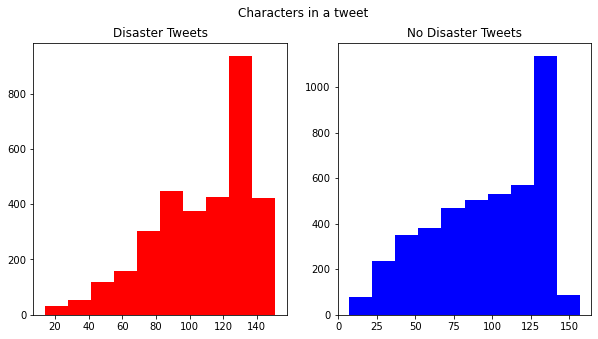

In [10]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
dis_len = df_train[df_train['target'] == 1]['text'].str.len()
ax1.hist(dis_len, color = 'red')
ax1.set_title('Disaster Tweets')
no_dis_len = df_train[df_train['target'] == 0]['text'].str.len()
ax2.hist(no_dis_len, color = 'blue')
ax2.set_title('No Disaster Tweets')
fig.suptitle('Characters in a tweet')
plt.show()

Average number of characters ranges between 120 - 140 characters for both disaster & non-disaster tweets

In [11]:
## Number of words in a text column
#%timeit train['word_count'] = train['text'].str.split().apply(len).value_counts() - This gives incorrect results & slower
df_train['word_count'] = df_train['text'].str.split().str.len()
df_test['word_count'] = df_test['text'].str.split().str.len()
#test['word_count'] = test['text'].str.split().apply(len).value_counts()
df_train.head()

,id,keyword,location,text,target,text_count,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


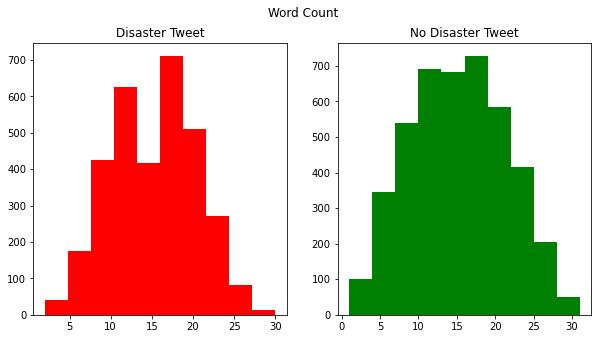

In [12]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
dis_word = df_train[df_train['target'] == 1]['word_count']
ax1.hist(dis_word, color = 'red')
ax1.set_title('Disaster Tweet')
no_dis_word = df_train[df_train['target'] == 0]['word_count']
ax2.hist(no_dis_word, color = 'green')
ax2.set_title('No Disaster Tweet')
fig.suptitle('Word Count')
plt.show()

Number of words across both disaster & non-disaster tweets is same

In [13]:
##  Count the number of capital letters
def find_capital_word(row):
    result = len([x for x in row if x.isupper()])
    return result

df_train['caps_word_in'] = df_train['text'].apply(lambda cw: find_capital_word(cw))
df_test['caps_word_in'] = df_test['text'].apply(lambda cw: find_capital_word(cw))

In [14]:
def senti_polarity(x):
    return TextBlob(x).sentiment.polarity

def senti_sub(x):
    return TextBlob(x).sentiment.subjectivity

df_train['polarity'] = df_train['text'].apply(senti_polarity)
df_train['subjectivity'] = df_train['text'].apply(senti_sub)

df_test['polarity'] = df_test['text'].apply(senti_polarity)
df_test['subjectivity'] = df_test['text'].apply(senti_sub)

In [15]:
## Count the number of hyperlinks in tweet
search = "http"

df_train['link_count'] = df_train['text'].str.count(search, re.I)
df_test['link_count'] = df_test['text'].str.count(search, re.I)

## Count the number of hashtags in tweet
search = "#"

df_train['hashtags'] = df_train['text'].str.count(search, re.I)
df_test['hashtags'] = df_test['text'].str.count(search, re.I)
df_train.head()

,id,keyword,location,text,target,text_count,word_count,caps_word_in,polarity,subjectivity,link_count,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,10,0.000,0.000,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,5,0.100,0.400,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,2,-0.019,0.388,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,0.000,0.000,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,3,0.000,0.000,0,2


In [16]:
!pip install pySpellChecker
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
df_train['text'] = df_train['text'].apply(lambda x: correct_spellings(x))
df_test['text'] = df_test['text'].apply(lambda x: correct_spellings(x))

     |████████████████████████████████| 1.9 MB 190 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
## CAPS word analysis - If number of caps word > 5 exists then there is a 50% chance disaster has occured
print(df_train[df_train['caps_word_in'] > 5].shape)
print(df_train[df_train['caps_word_in'] > 5]['target'].sum())

print(df_train[df_train['caps_word_in'] == 0].shape)
print(df_train[df_train['caps_word_in'] == 0]['target'].sum()) 

## Links analysis - If a link exists then there is a higher prob. of a disaster
print(df_train[df_train['link_count'] > 0].shape)
print(df_train[df_train['link_count'] > 0]['target'].sum())

print(df_train[df_train['link_count'] == 0].shape)
print(df_train[df_train['link_count'] == 0]['target'].sum())

(4679, 12)
2394
(278, 12)
57
(3971, 12)
2172
(3642, 12)
1099


In [18]:
## Polarity Analysis - If polarity is neutral there is alomost 50% chance that disaster has occured - negative tweet implies higher prob. of disaster
print(df_train[df_train['polarity'] > 0].shape)
print(df_train[df_train['polarity'] > 0]['target'].sum())

print(df_train[df_train['polarity'] == 0].shape)
print(df_train[df_train['polarity'] == 0]['target'].sum())

print(df_train[df_train['polarity'] < 0].shape)
print(df_train[df_train['polarity'] < 0]['target'].sum())

(2453, 12)
872
(3572, 12)
1647
(1588, 12)
752


In [19]:
## Hashtags analysis - If hashtag exists then there is a 50% chance disaster has occured
print(df_train[df_train['hashtags'] != 0].shape)
print(df_train[df_train['hashtags'] != 0]['target'].sum())

print(df_train[df_train['hashtags'] == 0].shape)
print(df_train[df_train['hashtags'] == 0]['target'].sum())

(1761, 12)
875
(5852, 12)
2396


In [20]:
temp_train = df_train[['caps_word_in', 'polarity', 'subjectivity', 'link_count', 'hashtags']]
temp_test = df_test[['caps_word_in', 'polarity', 'subjectivity', 'link_count', 'hashtags']]

temp_train['polarity'] = (temp_train['polarity'] - min(temp_train['polarity']))/(max(temp_train['polarity']) - min(temp_train['polarity']))
temp_test['polarity'] = (temp_test['polarity'] - min(temp_test['polarity']))/(max(temp_test['polarity']) - min(temp_test['polarity']))

temp_train.head()

,caps_word_in,polarity,subjectivity,link_count,hashtags
0,10,0.500,0.000,0,1
1,5,0.550,0.400,0,0
2,2,0.491,0.388,0,0
3,1,0.500,0.000,0,1
4,3,0.500,0.000,0,2


In [21]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [22]:
EMO_UNICODE = {
    u':1st_place_medal:': u'\U0001F947',
    u':2nd_place_medal:': u'\U0001F948',
    u':3rd_place_medal:': u'\U0001F949',
    u':AB_button_(blood_type):': u'\U0001F18E',
    u':ATM_sign:': u'\U0001F3E7',
    u':A_button_(blood_type):': u'\U0001F170',
    u':Afghanistan:': u'\U0001F1E6 \U0001F1EB',
    u':Albania:': u'\U0001F1E6 \U0001F1F1',
    u':Algeria:': u'\U0001F1E9 \U0001F1FF',
    u':American_Samoa:': u'\U0001F1E6 \U0001F1F8',
    u':Andorra:': u'\U0001F1E6 \U0001F1E9',
    u':Angola:': u'\U0001F1E6 \U0001F1F4',
    u':Anguilla:': u'\U0001F1E6 \U0001F1EE',
    u':Antarctica:': u'\U0001F1E6 \U0001F1F6',
    u':Antigua_&_Barbuda:': u'\U0001F1E6 \U0001F1EC',
    u':Aquarius:': u'\U00002652',
    u':Argentina:': u'\U0001F1E6 \U0001F1F7',
    u':Aries:': u'\U00002648',
    u':Armenia:': u'\U0001F1E6 \U0001F1F2',
    u':Aruba:': u'\U0001F1E6 \U0001F1FC',
    u':Ascension_Island:': u'\U0001F1E6 \U0001F1E8',
    u':Australia:': u'\U0001F1E6 \U0001F1FA',
    u':Austria:': u'\U0001F1E6 \U0001F1F9',
    u':Azerbaijan:': u'\U0001F1E6 \U0001F1FF',
    u':BACK_arrow:': u'\U0001F519',
    u':B_button_(blood_type):': u'\U0001F171',
    u':Bahamas:': u'\U0001F1E7 \U0001F1F8',
    u':Bahrain:': u'\U0001F1E7 \U0001F1ED',
    u':Bangladesh:': u'\U0001F1E7 \U0001F1E9',
    u':Barbados:': u'\U0001F1E7 \U0001F1E7',
    u':Belarus:': u'\U0001F1E7 \U0001F1FE',
    u':Belgium:': u'\U0001F1E7 \U0001F1EA',
    u':Belize:': u'\U0001F1E7 \U0001F1FF',
    u':Benin:': u'\U0001F1E7 \U0001F1EF',
    u':Bermuda:': u'\U0001F1E7 \U0001F1F2',
    u':Bhutan:': u'\U0001F1E7 \U0001F1F9',
    u':Bolivia:': u'\U0001F1E7 \U0001F1F4',
    u':Bosnia_&_Herzegovina:': u'\U0001F1E7 \U0001F1E6',
    u':Botswana:': u'\U0001F1E7 \U0001F1FC',
    u':Bouvet_Island:': u'\U0001F1E7 \U0001F1FB',
    u':Brazil:': u'\U0001F1E7 \U0001F1F7',
    u':British_Indian_Ocean_Territory:': u'\U0001F1EE \U0001F1F4',
    u':British_Virgin_Islands:': u'\U0001F1FB \U0001F1EC',
    u':Brunei:': u'\U0001F1E7 \U0001F1F3',
    u':Bulgaria:': u'\U0001F1E7 \U0001F1EC',
    u':Burkina_Faso:': u'\U0001F1E7 \U0001F1EB',
    u':Burundi:': u'\U0001F1E7 \U0001F1EE',
    u':CL_button:': u'\U0001F191',
    u':COOL_button:': u'\U0001F192',
    u':Cambodia:': u'\U0001F1F0 \U0001F1ED',
    u':Cameroon:': u'\U0001F1E8 \U0001F1F2',
    u':Canada:': u'\U0001F1E8 \U0001F1E6',
    u':Canary_Islands:': u'\U0001F1EE \U0001F1E8',
    u':Cancer:': u'\U0000264B',
    u':Cape_Verde:': u'\U0001F1E8 \U0001F1FB',
    u':Capricorn:': u'\U00002651',
    u':Caribbean_Netherlands:': u'\U0001F1E7 \U0001F1F6',
    u':Cayman_Islands:': u'\U0001F1F0 \U0001F1FE',
    u':Central_African_Republic:': u'\U0001F1E8 \U0001F1EB',
    u':Ceuta_&_Melilla:': u'\U0001F1EA \U0001F1E6',
    u':Chad:': u'\U0001F1F9 \U0001F1E9',
    u':Chile:': u'\U0001F1E8 \U0001F1F1',
    u':China:': u'\U0001F1E8 \U0001F1F3',
    u':Christmas_Island:': u'\U0001F1E8 \U0001F1FD',
    u':Christmas_tree:': u'\U0001F384',
    u':Clipperton_Island:': u'\U0001F1E8 \U0001F1F5',
    u':Cocos_(Keeling)_Islands:': u'\U0001F1E8 \U0001F1E8',
    u':Colombia:': u'\U0001F1E8 \U0001F1F4',
    u':Comoros:': u'\U0001F1F0 \U0001F1F2',
    u':Congo_-_Brazzaville:': u'\U0001F1E8 \U0001F1EC',
    u':Congo_-_Kinshasa:': u'\U0001F1E8 \U0001F1E9',
    u':Cook_Islands:': u'\U0001F1E8 \U0001F1F0',
    u':Costa_Rica:': u'\U0001F1E8 \U0001F1F7',
    u':Croatia:': u'\U0001F1ED \U0001F1F7',
    u':Cuba:': u'\U0001F1E8 \U0001F1FA',
    u':Curaçao:': u'\U0001F1E8 \U0001F1FC',
    u':Cyprus:': u'\U0001F1E8 \U0001F1FE',
    u':Czech_Republic:': u'\U0001F1E8 \U0001F1FF',
    u':Côte_d’Ivoire:': u'\U0001F1E8 \U0001F1EE',
    u':Denmark:': u'\U0001F1E9 \U0001F1F0',
    u':Diego_Garcia:': u'\U0001F1E9 \U0001F1EC',
    u':Djibouti:': u'\U0001F1E9 \U0001F1EF',
    u':Dominica:': u'\U0001F1E9 \U0001F1F2',
    u':Dominican_Republic:': u'\U0001F1E9 \U0001F1F4',
    u':END_arrow:': u'\U0001F51A',
    u':Ecuador:': u'\U0001F1EA \U0001F1E8',
    u':Egypt:': u'\U0001F1EA \U0001F1EC',
    u':El_Salvador:': u'\U0001F1F8 \U0001F1FB',
    u':Equatorial_Guinea:': u'\U0001F1EC \U0001F1F6',
    u':Eritrea:': u'\U0001F1EA \U0001F1F7',
    u':Estonia:': u'\U0001F1EA \U0001F1EA',
    u':Ethiopia:': u'\U0001F1EA \U0001F1F9',
    u':European_Union:': u'\U0001F1EA \U0001F1FA',
    u':FREE_button:': u'\U0001F193',
    u':Falkland_Islands:': u'\U0001F1EB \U0001F1F0',
    u':Faroe_Islands:': u'\U0001F1EB \U0001F1F4',
    u':Fiji:': u'\U0001F1EB \U0001F1EF',
    u':Finland:': u'\U0001F1EB \U0001F1EE',
    u':France:': u'\U0001F1EB \U0001F1F7',
    u':French_Guiana:': u'\U0001F1EC \U0001F1EB',
    u':French_Polynesia:': u'\U0001F1F5 \U0001F1EB',
    u':French_Southern_Territories:': u'\U0001F1F9 \U0001F1EB',
    u':Gabon:': u'\U0001F1EC \U0001F1E6',
    u':Gambia:': u'\U0001F1EC \U0001F1F2',
    u':Gemini:': u'\U0000264A',
    u':Georgia:': u'\U0001F1EC \U0001F1EA',
    u':Germany:': u'\U0001F1E9 \U0001F1EA',
    u':Ghana:': u'\U0001F1EC \U0001F1ED',
    u':Gibraltar:': u'\U0001F1EC \U0001F1EE',
    u':Greece:': u'\U0001F1EC \U0001F1F7',
    u':Greenland:': u'\U0001F1EC \U0001F1F1',
    u':Grenada:': u'\U0001F1EC \U0001F1E9',
    u':Guadeloupe:': u'\U0001F1EC \U0001F1F5',
    u':Guam:': u'\U0001F1EC \U0001F1FA',
    u':Guatemala:': u'\U0001F1EC \U0001F1F9',
    u':Guernsey:': u'\U0001F1EC \U0001F1EC',
    u':Guinea:': u'\U0001F1EC \U0001F1F3',
    u':Guinea-Bissau:': u'\U0001F1EC \U0001F1FC',
    u':Guyana:': u'\U0001F1EC \U0001F1FE',
    u':Haiti:': u'\U0001F1ED \U0001F1F9',
    u':Heard_&_McDonald_Islands:': u'\U0001F1ED \U0001F1F2',
    u':Honduras:': u'\U0001F1ED \U0001F1F3',
    u':Hong_Kong_SAR_China:': u'\U0001F1ED \U0001F1F0',
    u':Hungary:': u'\U0001F1ED \U0001F1FA',
    u':ID_button:': u'\U0001F194',
    u':Iceland:': u'\U0001F1EE \U0001F1F8',
    u':India:': u'\U0001F1EE \U0001F1F3',
    u':Indonesia:': u'\U0001F1EE \U0001F1E9',
    u':Iran:': u'\U0001F1EE \U0001F1F7',
    u':Iraq:': u'\U0001F1EE \U0001F1F6',
    u':Ireland:': u'\U0001F1EE \U0001F1EA',
    u':Isle_of_Man:': u'\U0001F1EE \U0001F1F2',
    u':Israel:': u'\U0001F1EE \U0001F1F1',
    u':Italy:': u'\U0001F1EE \U0001F1F9',
    u':Jamaica:': u'\U0001F1EF \U0001F1F2',
    u':Japan:': u'\U0001F1EF \U0001F1F5',
    u':Japanese_acceptable_button:': u'\U0001F251',
    u':Japanese_application_button:': u'\U0001F238',
    u':Japanese_bargain_button:': u'\U0001F250',
    u':Japanese_castle:': u'\U0001F3EF',
    u':Japanese_congratulations_button:': u'\U00003297',
    u':Japanese_discount_button:': u'\U0001F239',
    u':Japanese_dolls:': u'\U0001F38E',
    u':Japanese_free_of_charge_button:': u'\U0001F21A',
    u':Japanese_here_button:': u'\U0001F201',
    u':Japanese_monthly_amount_button:': u'\U0001F237',
    u':Japanese_no_vacancy_button:': u'\U0001F235',
    u':Japanese_not_free_of_charge_button:': u'\U0001F236',
    u':Japanese_open_for_business_button:': u'\U0001F23A',
    u':Japanese_passing_grade_button:': u'\U0001F234',
    u':Japanese_post_office:': u'\U0001F3E3',
    u':Japanese_prohibited_button:': u'\U0001F232',
    u':Japanese_reserved_button:': u'\U0001F22F',
    u':Japanese_secret_button:': u'\U00003299',
    u':Japanese_service_charge_button:': u'\U0001F202',
    u':Japanese_symbol_for_beginner:': u'\U0001F530',
    u':Japanese_vacancy_button:': u'\U0001F233',
    u':Jersey:': u'\U0001F1EF \U0001F1EA',
    u':Jordan:': u'\U0001F1EF \U0001F1F4',
    u':Kazakhstan:': u'\U0001F1F0 \U0001F1FF',
    u':Kenya:': u'\U0001F1F0 \U0001F1EA',
    u':Kiribati:': u'\U0001F1F0 \U0001F1EE',
    u':Kosovo:': u'\U0001F1FD \U0001F1F0',
    u':Kuwait:': u'\U0001F1F0 \U0001F1FC',
    u':Kyrgyzstan:': u'\U0001F1F0 \U0001F1EC',
    u':Laos:': u'\U0001F1F1 \U0001F1E6',
    u':Latvia:': u'\U0001F1F1 \U0001F1FB',
    u':Lebanon:': u'\U0001F1F1 \U0001F1E7',
    u':Leo:': u'\U0000264C',
    u':Lesotho:': u'\U0001F1F1 \U0001F1F8',
    u':Liberia:': u'\U0001F1F1 \U0001F1F7',
    u':Libra:': u'\U0000264E',
    u':Libya:': u'\U0001F1F1 \U0001F1FE',
    u':Liechtenstein:': u'\U0001F1F1 \U0001F1EE',
    u':Lithuania:': u'\U0001F1F1 \U0001F1F9',
    u':Luxembourg:': u'\U0001F1F1 \U0001F1FA',
    u':Macau_SAR_China:': u'\U0001F1F2 \U0001F1F4',
    u':Macedonia:': u'\U0001F1F2 \U0001F1F0',
    u':Madagascar:': u'\U0001F1F2 \U0001F1EC',
    u':Malawi:': u'\U0001F1F2 \U0001F1FC',
    u':Malaysia:': u'\U0001F1F2 \U0001F1FE',
    u':Maldives:': u'\U0001F1F2 \U0001F1FB',
    u':Mali:': u'\U0001F1F2 \U0001F1F1',
    u':Malta:': u'\U0001F1F2 \U0001F1F9',
    u':Marshall_Islands:': u'\U0001F1F2 \U0001F1ED',
    u':Martinique:': u'\U0001F1F2 \U0001F1F6',
    u':Mauritania:': u'\U0001F1F2 \U0001F1F7',
    u':Mauritius:': u'\U0001F1F2 \U0001F1FA',
    u':Mayotte:': u'\U0001F1FE \U0001F1F9',
    u':Mexico:': u'\U0001F1F2 \U0001F1FD',
    u':Micronesia:': u'\U0001F1EB \U0001F1F2',
    u':Moldova:': u'\U0001F1F2 \U0001F1E9',
    u':Monaco:': u'\U0001F1F2 \U0001F1E8',
    u':Mongolia:': u'\U0001F1F2 \U0001F1F3',
    u':Montenegro:': u'\U0001F1F2 \U0001F1EA',
    u':Montserrat:': u'\U0001F1F2 \U0001F1F8',
    u':Morocco:': u'\U0001F1F2 \U0001F1E6',
    u':Mozambique:': u'\U0001F1F2 \U0001F1FF',
    u':Mrs._Claus:': u'\U0001F936',
    u':Mrs._Claus_dark_skin_tone:': u'\U0001F936 \U0001F3FF',
    u':Mrs._Claus_light_skin_tone:': u'\U0001F936 \U0001F3FB',
    u':Mrs._Claus_medium-dark_skin_tone:': u'\U0001F936 \U0001F3FE',
    u':Mrs._Claus_medium-light_skin_tone:': u'\U0001F936 \U0001F3FC',
    u':Mrs._Claus_medium_skin_tone:': u'\U0001F936 \U0001F3FD',
    u':Myanmar_(Burma):': u'\U0001F1F2 \U0001F1F2',
    u':NEW_button:': u'\U0001F195',
    u':NG_button:': u'\U0001F196',
    u':Namibia:': u'\U0001F1F3 \U0001F1E6',
    u':Nauru:': u'\U0001F1F3 \U0001F1F7',
    u':Nepal:': u'\U0001F1F3 \U0001F1F5',
    u':Netherlands:': u'\U0001F1F3 \U0001F1F1',
    u':New_Caledonia:': u'\U0001F1F3 \U0001F1E8',
    u':New_Zealand:': u'\U0001F1F3 \U0001F1FF',
    u':Nicaragua:': u'\U0001F1F3 \U0001F1EE',
    u':Niger:': u'\U0001F1F3 \U0001F1EA',
    u':Nigeria:': u'\U0001F1F3 \U0001F1EC',
    u':Niue:': u'\U0001F1F3 \U0001F1FA',
    u':Norfolk_Island:': u'\U0001F1F3 \U0001F1EB',
    u':North_Korea:': u'\U0001F1F0 \U0001F1F5',
    u':Northern_Mariana_Islands:': u'\U0001F1F2 \U0001F1F5',
    u':Norway:': u'\U0001F1F3 \U0001F1F4',
    u':OK_button:': u'\U0001F197',
    u':OK_hand:': u'\U0001F44C',
    u':OK_hand_dark_skin_tone:': u'\U0001F44C \U0001F3FF',
    u':OK_hand_light_skin_tone:': u'\U0001F44C \U0001F3FB',
    u':OK_hand_medium-dark_skin_tone:': u'\U0001F44C \U0001F3FE',
    u':OK_hand_medium-light_skin_tone:': u'\U0001F44C \U0001F3FC',
    u':OK_hand_medium_skin_tone:': u'\U0001F44C \U0001F3FD',
    u':ON!_arrow:': u'\U0001F51B',
    u':O_button_(blood_type):': u'\U0001F17E',
    u':Oman:': u'\U0001F1F4 \U0001F1F2',
    u':Ophiuchus:': u'\U000026CE',
    u':P_button:': u'\U0001F17F',
    u':Pakistan:': u'\U0001F1F5 \U0001F1F0',
    u':Palau:': u'\U0001F1F5 \U0001F1FC',
    u':Palestinian_Territories:': u'\U0001F1F5 \U0001F1F8',
    u':Panama:': u'\U0001F1F5 \U0001F1E6',
    u':Papua_New_Guinea:': u'\U0001F1F5 \U0001F1EC',
    u':Paraguay:': u'\U0001F1F5 \U0001F1FE',
    u':Peru:': u'\U0001F1F5 \U0001F1EA',
    u':Philippines:': u'\U0001F1F5 \U0001F1ED',
    u':Pisces:': u'\U00002653',
    u':Pitcairn_Islands:': u'\U0001F1F5 \U0001F1F3',
    u':Poland:': u'\U0001F1F5 \U0001F1F1',
    u':Portugal:': u'\U0001F1F5 \U0001F1F9',
    u':Puerto_Rico:': u'\U0001F1F5 \U0001F1F7',
    u':Qatar:': u'\U0001F1F6 \U0001F1E6',
    u':Romania:': u'\U0001F1F7 \U0001F1F4',
    u':Russia:': u'\U0001F1F7 \U0001F1FA',
    u':Rwanda:': u'\U0001F1F7 \U0001F1FC',
    u':Réunion:': u'\U0001F1F7 \U0001F1EA',
    u':SOON_arrow:': u'\U0001F51C',
    u':SOS_button:': u'\U0001F198',
    u':Sagittarius:': u'\U00002650',
    u':Samoa:': u'\U0001F1FC \U0001F1F8',
    u':San_Marino:': u'\U0001F1F8 \U0001F1F2',
    u':Santa_Claus:': u'\U0001F385',
    u':Santa_Claus_dark_skin_tone:': u'\U0001F385 \U0001F3FF',
    u':Santa_Claus_light_skin_tone:': u'\U0001F385 \U0001F3FB',
    u':Santa_Claus_medium-dark_skin_tone:': u'\U0001F385 \U0001F3FE',
    u':Santa_Claus_medium-light_skin_tone:': u'\U0001F385 \U0001F3FC',
    u':Santa_Claus_medium_skin_tone:': u'\U0001F385 \U0001F3FD',
    u':Saudi_Arabia:': u'\U0001F1F8 \U0001F1E6',
    u':Scorpius:': u'\U0000264F',
    u':Senegal:': u'\U0001F1F8 \U0001F1F3',
    u':Serbia:': u'\U0001F1F7 \U0001F1F8',
    u':Seychelles:': u'\U0001F1F8 \U0001F1E8',
    u':Sierra_Leone:': u'\U0001F1F8 \U0001F1F1',
    u':Singapore:': u'\U0001F1F8 \U0001F1EC',
    u':Sint_Maarten:': u'\U0001F1F8 \U0001F1FD',
    u':Slovakia:': u'\U0001F1F8 \U0001F1F0',
    u':Slovenia:': u'\U0001F1F8 \U0001F1EE',
    u':Solomon_Islands:': u'\U0001F1F8 \U0001F1E7',
    u':Somalia:': u'\U0001F1F8 \U0001F1F4',
    u':South_Africa:': u'\U0001F1FF \U0001F1E6',
    u':South_Georgia_&_South_Sandwich_Islands:': u'\U0001F1EC \U0001F1F8',
    u':South_Korea:': u'\U0001F1F0 \U0001F1F7',
    u':South_Sudan:': u'\U0001F1F8 \U0001F1F8',
    u':Spain:': u'\U0001F1EA \U0001F1F8',
    u':Sri_Lanka:': u'\U0001F1F1 \U0001F1F0',
    u':St._Barthélemy:': u'\U0001F1E7 \U0001F1F1',
    u':St._Helena:': u'\U0001F1F8 \U0001F1ED',
    u':St._Kitts_&_Nevis:': u'\U0001F1F0 \U0001F1F3',
    u':St._Lucia:': u'\U0001F1F1 \U0001F1E8',
    u':St._Martin:': u'\U0001F1F2 \U0001F1EB',
    u':St._Pierre_&_Miquelon:': u'\U0001F1F5 \U0001F1F2',
    u':St._Vincent_&_Grenadines:': u'\U0001F1FB \U0001F1E8',
    u':Statue_of_Liberty:': u'\U0001F5FD',
    u':Sudan:': u'\U0001F1F8 \U0001F1E9',
    u':Suriname:': u'\U0001F1F8 \U0001F1F7',
    u':Svalbard_&_Jan_Mayen:': u'\U0001F1F8 \U0001F1EF',
    u':Swaziland:': u'\U0001F1F8 \U0001F1FF',
    u':Sweden:': u'\U0001F1F8 \U0001F1EA',
    u':Switzerland:': u'\U0001F1E8 \U0001F1ED',
    u':Syria:': u'\U0001F1F8 \U0001F1FE',
    u':São_Tomé_&_Príncipe:': u'\U0001F1F8 \U0001F1F9',
    u':TOP_arrow:': u'\U0001F51D',
    u':Taiwan:': u'\U0001F1F9 \U0001F1FC',
    u':Tajikistan:': u'\U0001F1F9 \U0001F1EF',
    u':Tanzania:': u'\U0001F1F9 \U0001F1FF',
    u':Taurus:': u'\U00002649',
    u':Thailand:': u'\U0001F1F9 \U0001F1ED',
    u':Timor-Leste:': u'\U0001F1F9 \U0001F1F1',
    u':Togo:': u'\U0001F1F9 \U0001F1EC',
    u':Tokelau:': u'\U0001F1F9 \U0001F1F0',
    u':Tokyo_tower:': u'\U0001F5FC',
    u':Tonga:': u'\U0001F1F9 \U0001F1F4',
    u':Trinidad_&_Tobago:': u'\U0001F1F9 \U0001F1F9',
    u':Tristan_da_Cunha:': u'\U0001F1F9 \U0001F1E6',
    u':Tunisia:': u'\U0001F1F9 \U0001F1F3',
    u':Turkey:': u'\U0001F1F9 \U0001F1F7',
    u':Turkmenistan:': u'\U0001F1F9 \U0001F1F2',
    u':Turks_&_Caicos_Islands:': u'\U0001F1F9 \U0001F1E8',
    u':Tuvalu:': u'\U0001F1F9 \U0001F1FB',
    u':U.S._Outlying_Islands:': u'\U0001F1FA \U0001F1F2',
    u':U.S._Virgin_Islands:': u'\U0001F1FB \U0001F1EE',
    u':UP!_button:': u'\U0001F199',
    u':Uganda:': u'\U0001F1FA \U0001F1EC',
    u':Ukraine:': u'\U0001F1FA \U0001F1E6',
    u':United_Arab_Emirates:': u'\U0001F1E6 \U0001F1EA',
    u':United_Kingdom:': u'\U0001F1EC \U0001F1E7',
    u':United_Nations:': u'\U0001F1FA \U0001F1F3',
    u':United_States:': u'\U0001F1FA \U0001F1F8',
    u':Uruguay:': u'\U0001F1FA \U0001F1FE',
    u':Uzbekistan:': u'\U0001F1FA \U0001F1FF',
    u':VS_button:': u'\U0001F19A',
    u':Vanuatu:': u'\U0001F1FB \U0001F1FA',
    u':Vatican_City:': u'\U0001F1FB \U0001F1E6',
    u':Venezuela:': u'\U0001F1FB \U0001F1EA',
    u':Vietnam:': u'\U0001F1FB \U0001F1F3',
    u':Virgo:': u'\U0000264D',
    u':Wallis_&_Futuna:': u'\U0001F1FC \U0001F1EB',
    u':Western_Sahara:': u'\U0001F1EA \U0001F1ED',
    u':Yemen:': u'\U0001F1FE \U0001F1EA',
    u':Zambia:': u'\U0001F1FF \U0001F1F2',
    u':Zimbabwe:': u'\U0001F1FF \U0001F1FC',
    u':admission_tickets:': u'\U0001F39F',
    u':aerial_tramway:': u'\U0001F6A1',
    u':airplane:': u'\U00002708',
    u':airplane_arrival:': u'\U0001F6EC',
    u':airplane_departure:': u'\U0001F6EB',
    u':alarm_clock:': u'\U000023F0',
    u':alembic:': u'\U00002697',
    u':alien:': u'\U0001F47D',
    u':alien_monster:': u'\U0001F47E',
    u':ambulance:': u'\U0001F691',
    u':american_football:': u'\U0001F3C8',
    u':amphora:': u'\U0001F3FA',
    u':anchor:': u'\U00002693',
    u':anger_symbol:': u'\U0001F4A2',
    u':angry_face:': u'\U0001F620',
    u':angry_face_with_horns:': u'\U0001F47F',
    u':anguished_face:': u'\U0001F627',
    u':ant:': u'\U0001F41C',
    u':antenna_bars:': u'\U0001F4F6',
    u':anticlockwise_arrows_button:': u'\U0001F504',
    u':articulated_lorry:': u'\U0001F69B',
    u':artist_palette:': u'\U0001F3A8',
    u':astonished_face:': u'\U0001F632',
    u':atom_symbol:': u'\U0000269B',
    u':automobile:': u'\U0001F697',
    u':avocado:': u'\U0001F951',
    u':baby:': u'\U0001F476',
    u':baby_angel:': u'\U0001F47C',
    u':baby_angel_dark_skin_tone:': u'\U0001F47C \U0001F3FF',
    u':baby_angel_light_skin_tone:': u'\U0001F47C \U0001F3FB',
    u':baby_angel_medium-dark_skin_tone:': u'\U0001F47C \U0001F3FE',
    u':baby_angel_medium-light_skin_tone:': u'\U0001F47C \U0001F3FC',
    u':baby_angel_medium_skin_tone:': u'\U0001F47C \U0001F3FD',
    u':baby_bottle:': u'\U0001F37C',
    u':baby_chick:': u'\U0001F424',
    u':baby_dark_skin_tone:': u'\U0001F476 \U0001F3FF',
    u':baby_light_skin_tone:': u'\U0001F476 \U0001F3FB',
    u':baby_medium-dark_skin_tone:': u'\U0001F476 \U0001F3FE',
    u':baby_medium-light_skin_tone:': u'\U0001F476 \U0001F3FC',
    u':baby_medium_skin_tone:': u'\U0001F476 \U0001F3FD',
    u':baby_symbol:': u'\U0001F6BC',
    u':backhand_index_pointing_down:': u'\U0001F447',
    u':backhand_index_pointing_down_dark_skin_tone:': u'\U0001F447 \U0001F3FF',
    u':backhand_index_pointing_down_light_skin_tone:': u'\U0001F447 \U0001F3FB',
    u':backhand_index_pointing_down_medium-dark_skin_tone:': u'\U0001F447 \U0001F3FE',
    u':backhand_index_pointing_down_medium-light_skin_tone:': u'\U0001F447 \U0001F3FC',
    u':backhand_index_pointing_down_medium_skin_tone:': u'\U0001F447 \U0001F3FD',
    u':backhand_index_pointing_left:': u'\U0001F448',
    u':backhand_index_pointing_left_dark_skin_tone:': u'\U0001F448 \U0001F3FF',
    u':backhand_index_pointing_left_light_skin_tone:': u'\U0001F448 \U0001F3FB',
    u':backhand_index_pointing_left_medium-dark_skin_tone:': u'\U0001F448 \U0001F3FE',
    u':backhand_index_pointing_left_medium-light_skin_tone:': u'\U0001F448 \U0001F3FC',
    u':backhand_index_pointing_left_medium_skin_tone:': u'\U0001F448 \U0001F3FD',
    u':backhand_index_pointing_right:': u'\U0001F449',
    u':backhand_index_pointing_right_dark_skin_tone:': u'\U0001F449 \U0001F3FF',
    u':backhand_index_pointing_right_light_skin_tone:': u'\U0001F449 \U0001F3FB',
    u':backhand_index_pointing_right_medium-dark_skin_tone:': u'\U0001F449 \U0001F3FE',
    u':backhand_index_pointing_right_medium-light_skin_tone:': u'\U0001F449 \U0001F3FC',
    u':backhand_index_pointing_right_medium_skin_tone:': u'\U0001F449 \U0001F3FD',
    u':backhand_index_pointing_up:': u'\U0001F446',
    u':backhand_index_pointing_up_dark_skin_tone:': u'\U0001F446 \U0001F3FF',
    u':backhand_index_pointing_up_light_skin_tone:': u'\U0001F446 \U0001F3FB',
    u':backhand_index_pointing_up_medium-dark_skin_tone:': u'\U0001F446 \U0001F3FE',
    u':backhand_index_pointing_up_medium-light_skin_tone:': u'\U0001F446 \U0001F3FC',
    u':backhand_index_pointing_up_medium_skin_tone:': u'\U0001F446 \U0001F3FD',
    u':bacon:': u'\U0001F953',
    u':badminton:': u'\U0001F3F8',
    u':baggage_claim:': u'\U0001F6C4',
    u':baguette_bread:': u'\U0001F956',
    u':balance_scale:': u'\U00002696',
    u':balloon:': u'\U0001F388',
    u':ballot_box_with_ballot:': u'\U0001F5F3',
    u':ballot_box_with_check:': u'\U00002611',
    u':banana:': u'\U0001F34C',
    u':bank:': u'\U0001F3E6',
    u':bar_chart:': u'\U0001F4CA',
    u':barber_pole:': u'\U0001F488',
    u':baseball:': u'\U000026BE',
    u':basketball:': u'\U0001F3C0',
    u':bat:': u'\U0001F987',
    u':bathtub:': u'\U0001F6C1',
    u':battery:': u'\U0001F50B',
    u':beach_with_umbrella:': u'\U0001F3D6',
    u':bear_face:': u'\U0001F43B',
    u':beating_heart:': u'\U0001F493',
    u':bed:': u'\U0001F6CF',
    u':beer_mug:': u'\U0001F37A',
    u':bell:': u'\U0001F514',
    u':bell_with_slash:': u'\U0001F515',
    u':bellhop_bell:': u'\U0001F6CE',
    u':bento_box:': u'\U0001F371',
    u':bicycle:': u'\U0001F6B2',
    u':bikini:': u'\U0001F459',
    u':biohazard:': u'\U00002623',
    u':bird:': u'\U0001F426',
    u':birthday_cake:': u'\U0001F382',
    u':black_circle:': u'\U000026AB',
    u':black_flag:': u'\U0001F3F4',
    u':black_heart:': u'\U0001F5A4',
    u':black_large_square:': u'\U00002B1B',
    u':black_medium-small_square:': u'\U000025FE',
    u':black_medium_square:': u'\U000025FC',
    u':black_nib:': u'\U00002712',
    u':black_small_square:': u'\U000025AA',
    u':black_square_button:': u'\U0001F532',
    u':blond-haired_man:': u'\U0001F471 \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_person:': u'\U0001F471',
    u':blond-haired_person_dark_skin_tone:': u'\U0001F471 \U0001F3FF',
    u':blond-haired_person_light_skin_tone:': u'\U0001F471 \U0001F3FB',
    u':blond-haired_person_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE',
    u':blond-haired_person_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC',
    u':blond-haired_person_medium_skin_tone:': u'\U0001F471 \U0001F3FD',
    u':blond-haired_woman:': u'\U0001F471 \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':blossom:': u'\U0001F33C',
    u':blowfish:': u'\U0001F421',
    u':blue_book:': u'\U0001F4D8',
    u':blue_circle:': u'\U0001F535',
    u':blue_heart:': u'\U0001F499',
    u':boar:': u'\U0001F417',
    u':bomb:': u'\U0001F4A3',
    u':bookmark:': u'\U0001F516',
    u':bookmark_tabs:': u'\U0001F4D1',
    u':books:': u'\U0001F4DA',
    u':bottle_with_popping_cork:': u'\U0001F37E',
    u':bouquet:': u'\U0001F490',
    u':bow_and_arrow:': u'\U0001F3F9',
    u':bowling:': u'\U0001F3B3',
    u':boxing_glove:': u'\U0001F94A',
    u':boy:': u'\U0001F466',
    u':boy_dark_skin_tone:': u'\U0001F466 \U0001F3FF',
    u':boy_light_skin_tone:': u'\U0001F466 \U0001F3FB',
    u':boy_medium-dark_skin_tone:': u'\U0001F466 \U0001F3FE',
    u':boy_medium-light_skin_tone:': u'\U0001F466 \U0001F3FC',
    u':boy_medium_skin_tone:': u'\U0001F466 \U0001F3FD',
    u':bread:': u'\U0001F35E',
    u':bride_with_veil:': u'\U0001F470',
    u':bride_with_veil_dark_skin_tone:': u'\U0001F470 \U0001F3FF',
    u':bride_with_veil_light_skin_tone:': u'\U0001F470 \U0001F3FB',
    u':bride_with_veil_medium-dark_skin_tone:': u'\U0001F470 \U0001F3FE',
    u':bride_with_veil_medium-light_skin_tone:': u'\U0001F470 \U0001F3FC',
    u':bride_with_veil_medium_skin_tone:': u'\U0001F470 \U0001F3FD',
    u':bridge_at_night:': u'\U0001F309',
    u':briefcase:': u'\U0001F4BC',
    u':bright_button:': u'\U0001F506',
    u':broken_heart:': u'\U0001F494',
    u':bug:': u'\U0001F41B',
    u':building_construction:': u'\U0001F3D7',
    u':burrito:': u'\U0001F32F',
    u':bus:': u'\U0001F68C',
    u':bus_stop:': u'\U0001F68F',
    u':bust_in_silhouette:': u'\U0001F464',
    u':busts_in_silhouette:': u'\U0001F465',
    u':butterfly:': u'\U0001F98B',
    u':cactus:': u'\U0001F335',
    u':calendar:': u'\U0001F4C5',
    u':call_me_hand:': u'\U0001F919',
    u':call_me_hand_dark_skin_tone:': u'\U0001F919 \U0001F3FF',
    u':call_me_hand_light_skin_tone:': u'\U0001F919 \U0001F3FB',
    u':call_me_hand_medium-dark_skin_tone:': u'\U0001F919 \U0001F3FE',
    u':call_me_hand_medium-light_skin_tone:': u'\U0001F919 \U0001F3FC',
    u':call_me_hand_medium_skin_tone:': u'\U0001F919 \U0001F3FD',
    u':camel:': u'\U0001F42A',
    u':camera:': u'\U0001F4F7',
    u':camera_with_flash:': u'\U0001F4F8',
    u':camping:': u'\U0001F3D5',
    u':candle:': u'\U0001F56F',
    u':candy:': u'\U0001F36C',
    u':canoe:': u'\U0001F6F6',
    u':card_file_box:': u'\U0001F5C3',
    u':card_index:': u'\U0001F4C7',
    u':card_index_dividers:': u'\U0001F5C2',
    u':carousel_horse:': u'\U0001F3A0',
    u':carp_streamer:': u'\U0001F38F',
    u':carrot:': u'\U0001F955',
    u':castle:': u'\U0001F3F0',
    u':cat:': u'\U0001F408',
    u':cat_face:': u'\U0001F431',
    u':cat_face_with_tears_of_joy:': u'\U0001F639',
    u':cat_face_with_wry_smile:': u'\U0001F63C',
    u':chains:': u'\U000026D3',
    u':chart_decreasing:': u'\U0001F4C9',
    u':chart_increasing:': u'\U0001F4C8',
    u':chart_increasing_with_yen:': u'\U0001F4B9',
    u':cheese_wedge:': u'\U0001F9C0',
    u':chequered_flag:': u'\U0001F3C1',
    u':cherries:': u'\U0001F352',
    u':cherry_blossom:': u'\U0001F338',
    u':chestnut:': u'\U0001F330',
    u':chicken:': u'\U0001F414',
    u':children_crossing:': u'\U0001F6B8',
    u':chipmunk:': u'\U0001F43F',
    u':chocolate_bar:': u'\U0001F36B',
    u':church:': u'\U000026EA',
    u':cigarette:': u'\U0001F6AC',
    u':cinema:': u'\U0001F3A6',
    u':circled_M:': u'\U000024C2',
    u':circus_tent:': u'\U0001F3AA',
    u':cityscape:': u'\U0001F3D9',
    u':cityscape_at_dusk:': u'\U0001F306',
    u':clamp:': u'\U0001F5DC',
    u':clapper_board:': u'\U0001F3AC',
    u':clapping_hands:': u'\U0001F44F',
    u':clapping_hands_dark_skin_tone:': u'\U0001F44F \U0001F3FF',
    u':clapping_hands_light_skin_tone:': u'\U0001F44F \U0001F3FB',
    u':clapping_hands_medium-dark_skin_tone:': u'\U0001F44F \U0001F3FE',
    u':clapping_hands_medium-light_skin_tone:': u'\U0001F44F \U0001F3FC',
    u':clapping_hands_medium_skin_tone:': u'\U0001F44F \U0001F3FD',
    u':classical_building:': u'\U0001F3DB',
    u':clinking_beer_mugs:': u'\U0001F37B',
    u':clinking_glasses:': u'\U0001F942',
    u':clipboard:': u'\U0001F4CB',
    u':clockwise_vertical_arrows:': u'\U0001F503',
    u':closed_book:': u'\U0001F4D5',
    u':closed_mailbox_with_lowered_flag:': u'\U0001F4EA',
    u':closed_mailbox_with_raised_flag:': u'\U0001F4EB',
    u':closed_umbrella:': u'\U0001F302',
    u':cloud:': u'\U00002601',
    u':cloud_with_lightning:': u'\U0001F329',
    u':cloud_with_lightning_and_rain:': u'\U000026C8',
    u':cloud_with_rain:': u'\U0001F327',
    u':cloud_with_snow:': u'\U0001F328',
    u':clown_face:': u'\U0001F921',
    u':club_suit:': u'\U00002663',
    u':clutch_bag:': u'\U0001F45D',
    u':cocktail_glass:': u'\U0001F378',
    u':coffin:': u'\U000026B0',
    u':collision:': u'\U0001F4A5',
    u':comet:': u'\U00002604',
    u':computer_disk:': u'\U0001F4BD',
    u':computer_mouse:': u'\U0001F5B1',
    u':confetti_ball:': u'\U0001F38A',
    u':confounded_face:': u'\U0001F616',
    u':confused_face:': u'\U0001F615',
    u':construction:': u'\U0001F6A7',
    u':construction_worker:': u'\U0001F477',
    u':construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF',
    u':construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB',
    u':construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE',
    u':construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC',
    u':construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD',
    u':control_knobs:': u'\U0001F39B',
    u':convenience_store:': u'\U0001F3EA',
    u':cooked_rice:': u'\U0001F35A',
    u':cookie:': u'\U0001F36A',
    u':cooking:': u'\U0001F373',
    u':copyright:': u'\U000000A9',
    u':couch_and_lamp:': u'\U0001F6CB',
    u':couple_with_heart:': u'\U0001F491',
    u':couple_with_heart_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F469',
    u':cow:': u'\U0001F404',
    u':cow_face:': u'\U0001F42E',
    u':cowboy_hat_face:': u'\U0001F920',
    u':crab:': u'\U0001F980',
    u':crayon:': u'\U0001F58D',
    u':credit_card:': u'\U0001F4B3',
    u':crescent_moon:': u'\U0001F319',
    u':cricket:': u'\U0001F3CF',
    u':crocodile:': u'\U0001F40A',
    u':croissant:': u'\U0001F950',
    u':cross_mark:': u'\U0000274C',
    u':cross_mark_button:': u'\U0000274E',
    u':crossed_fingers:': u'\U0001F91E',
    u':crossed_fingers_dark_skin_tone:': u'\U0001F91E \U0001F3FF',
    u':crossed_fingers_light_skin_tone:': u'\U0001F91E \U0001F3FB',
    u':crossed_fingers_medium-dark_skin_tone:': u'\U0001F91E \U0001F3FE',
    u':crossed_fingers_medium-light_skin_tone:': u'\U0001F91E \U0001F3FC',
    u':crossed_fingers_medium_skin_tone:': u'\U0001F91E \U0001F3FD',
    u':crossed_flags:': u'\U0001F38C',
    u':crossed_swords:': u'\U00002694',
    u':crown:': u'\U0001F451',
    u':crying_cat_face:': u'\U0001F63F',
    u':crying_face:': u'\U0001F622',
    u':crystal_ball:': u'\U0001F52E',
    u':cucumber:': u'\U0001F952',
    u':curly_loop:': u'\U000027B0',
    u':currency_exchange:': u'\U0001F4B1',
    u':curry_rice:': u'\U0001F35B',
    u':custard:': u'\U0001F36E',
    u':customs:': u'\U0001F6C3',
    u':cyclone:': u'\U0001F300',
    u':dagger:': u'\U0001F5E1',
    u':dango:': u'\U0001F361',
    u':dark_skin_tone:': u'\U0001F3FF',
    u':dashing_away:': u'\U0001F4A8',
    u':deciduous_tree:': u'\U0001F333',
    u':deer:': u'\U0001F98C',
    u':delivery_truck:': u'\U0001F69A',
    u':department_store:': u'\U0001F3EC',
    u':derelict_house:': u'\U0001F3DA',
    u':desert:': u'\U0001F3DC',
    u':desert_island:': u'\U0001F3DD',
    u':desktop_computer:': u'\U0001F5A5',
    u':detective:': u'\U0001F575',
    u':detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF',
    u':detective_light_skin_tone:': u'\U0001F575 \U0001F3FB',
    u':detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE',
    u':detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC',
    u':detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD',
    u':diamond_suit:': u'\U00002666',
    u':diamond_with_a_dot:': u'\U0001F4A0',
    u':dim_button:': u'\U0001F505',
    u':direct_hit:': u'\U0001F3AF',
    u':disappointed_but_relieved_face:': u'\U0001F625',
    u':disappointed_face:': u'\U0001F61E',
    u':dizzy:': u'\U0001F4AB',
    u':dizzy_face:': u'\U0001F635',
    u':dog:': u'\U0001F415',
    u':dog_face:': u'\U0001F436',
    u':dollar_banknote:': u'\U0001F4B5',
    u':dolphin:': u'\U0001F42C',
    u':door:': u'\U0001F6AA',
    u':dotted_six-pointed_star:': u'\U0001F52F',
    u':double_curly_loop:': u'\U000027BF',
    u':double_exclamation_mark:': u'\U0000203C',
    u':doughnut:': u'\U0001F369',
    u':dove:': u'\U0001F54A',
    u':down-left_arrow:': u'\U00002199',
    u':down-right_arrow:': u'\U00002198',
    u':down_arrow:': u'\U00002B07',
    u':down_button:': u'\U0001F53D',
    u':dragon:': u'\U0001F409',
    u':dragon_face:': u'\U0001F432',
    u':dress:': u'\U0001F457',
    u':drooling_face:': u'\U0001F924',
    u':droplet:': u'\U0001F4A7',
    u':drum:': u'\U0001F941',
    u':duck:': u'\U0001F986',
    u':dvd:': u'\U0001F4C0',
    u':e-mail:': u'\U0001F4E7',
    u':eagle:': u'\U0001F985',
    u':ear:': u'\U0001F442',
    u':ear_dark_skin_tone:': u'\U0001F442 \U0001F3FF',
    u':ear_light_skin_tone:': u'\U0001F442 \U0001F3FB',
    u':ear_medium-dark_skin_tone:': u'\U0001F442 \U0001F3FE',
    u':ear_medium-light_skin_tone:': u'\U0001F442 \U0001F3FC',
    u':ear_medium_skin_tone:': u'\U0001F442 \U0001F3FD',
    u':ear_of_corn:': u'\U0001F33D',
    u':egg:': u'\U0001F95A',
    u':eggplant:': u'\U0001F346',
    u':eight-pointed_star:': u'\U00002734',
    u':eight-spoked_asterisk:': u'\U00002733',
    u':eight-thirty:': u'\U0001F563',
    u':eight_o’clock:': u'\U0001F557',
    u':eject_button:': u'\U000023CF',
    u':electric_plug:': u'\U0001F50C',
    u':elephant:': u'\U0001F418',
    u':eleven-thirty:': u'\U0001F566',
    u':eleven_o’clock:': u'\U0001F55A',
    u':envelope:': u'\U00002709',
    u':envelope_with_arrow:': u'\U0001F4E9',
    u':euro_banknote:': u'\U0001F4B6',
    u':evergreen_tree:': u'\U0001F332',
    u':exclamation_mark:': u'\U00002757',
    u':exclamation_question_mark:': u'\U00002049',
    u':expressionless_face:': u'\U0001F611',
    u':eye:': u'\U0001F441',
    u':eye_in_speech_bubble:': u'\U0001F441 \U0000FE0F \U0000200D \U0001F5E8 \U0000FE0F',
    u':eyes:': u'\U0001F440',
    u':face_blowing_a_kiss:': u'\U0001F618',
    u':face_savouring_delicious_food:': u'\U0001F60B',
    u':face_screaming_in_fear:': u'\U0001F631',
    u':face_with_cold_sweat:': u'\U0001F613',
    u':face_with_head-bandage:': u'\U0001F915',
    u':face_with_medical_mask:': u'\U0001F637',
    u':face_with_open_mouth:': u'\U0001F62E',
    u':face_with_open_mouth_&_cold_sweat:': u'\U0001F630',
    u':face_with_rolling_eyes:': u'\U0001F644',
    u':face_with_steam_from_nose:': u'\U0001F624',
    u':face_with_stuck-out_tongue:': u'\U0001F61B',
    u':face_with_stuck-out_tongue_&_closed_eyes:': u'\U0001F61D',
    u':face_with_stuck-out_tongue_&_winking_eye:': u'\U0001F61C',
    u':face_with_tears_of_joy:': u'\U0001F602',
    u':face_with_thermometer:': u'\U0001F912',
    u':face_without_mouth:': u'\U0001F636',
    u':factory:': u'\U0001F3ED',
    u':fallen_leaf:': u'\U0001F342',
    u':family:': u'\U0001F46A',
    u':family_man_boy:': u'\U0001F468 \U0000200D \U0001F466',
    u':family_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_girl:': u'\U0001F468 \U0000200D \U0001F467',
    u':family_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_man_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466',
    u':family_man_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_man_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467',
    u':family_man_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_woman_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_man_woman_boy_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_woman_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_man_woman_girl_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_woman_girl_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_boy:': u'\U0001F469 \U0000200D \U0001F466',
    u':family_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_girl:': u'\U0001F469 \U0000200D \U0001F467',
    u':family_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_woman_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_woman_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_woman_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_woman_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':fast-forward_button:': u'\U000023E9',
    u':fast_down_button:': u'\U000023EC',
    u':fast_reverse_button:': u'\U000023EA',
    u':fast_up_button:': u'\U000023EB',
    u':fax_machine:': u'\U0001F4E0',
    u':fearful_face:': u'\U0001F628',
    u':female_sign:': u'\U00002640',
    u':ferris_wheel:': u'\U0001F3A1',
    u':ferry:': u'\U000026F4',
    u':field_hockey:': u'\U0001F3D1',
    u':file_cabinet:': u'\U0001F5C4',
    u':file_folder:': u'\U0001F4C1',
    u':film_frames:': u'\U0001F39E',
    u':film_projector:': u'\U0001F4FD',
    u':fire:': u'\U0001F525',
    u':fire_engine:': u'\U0001F692',
    u':fireworks:': u'\U0001F386',
    u':first_quarter_moon:': u'\U0001F313',
    u':first_quarter_moon_with_face:': u'\U0001F31B',
    u':fish:': u'\U0001F41F',
    u':fish_cake_with_swirl:': u'\U0001F365',
    u':fishing_pole:': u'\U0001F3A3',
    u':five-thirty:': u'\U0001F560',
    u':five_o’clock:': u'\U0001F554',
    u':flag_in_hole:': u'\U000026F3',
    u':flashlight:': u'\U0001F526',
    u':fleur-de-lis:': u'\U0000269C',
    u':flexed_biceps:': u'\U0001F4AA',
    u':flexed_biceps_dark_skin_tone:': u'\U0001F4AA \U0001F3FF',
    u':flexed_biceps_light_skin_tone:': u'\U0001F4AA \U0001F3FB',
    u':flexed_biceps_medium-dark_skin_tone:': u'\U0001F4AA \U0001F3FE',
    u':flexed_biceps_medium-light_skin_tone:': u'\U0001F4AA \U0001F3FC',
    u':flexed_biceps_medium_skin_tone:': u'\U0001F4AA \U0001F3FD',
    u':floppy_disk:': u'\U0001F4BE',
    u':flower_playing_cards:': u'\U0001F3B4',
    u':flushed_face:': u'\U0001F633',
    u':fog:': u'\U0001F32B',
    u':foggy:': u'\U0001F301',
    u':folded_hands:': u'\U0001F64F',
    u':folded_hands_dark_skin_tone:': u'\U0001F64F \U0001F3FF',
    u':folded_hands_light_skin_tone:': u'\U0001F64F \U0001F3FB',
    u':folded_hands_medium-dark_skin_tone:': u'\U0001F64F \U0001F3FE',
    u':folded_hands_medium-light_skin_tone:': u'\U0001F64F \U0001F3FC',
    u':folded_hands_medium_skin_tone:': u'\U0001F64F \U0001F3FD',
    u':footprints:': u'\U0001F463',
    u':fork_and_knife:': u'\U0001F374',
    u':fork_and_knife_with_plate:': u'\U0001F37D',
    u':fountain:': u'\U000026F2',
    u':fountain_pen:': u'\U0001F58B',
    u':four-thirty:': u'\U0001F55F',
    u':four_leaf_clover:': u'\U0001F340',
    u':four_o’clock:': u'\U0001F553',
    u':fox_face:': u'\U0001F98A',
    u':framed_picture:': u'\U0001F5BC',
    u':french_fries:': u'\U0001F35F',
    u':fried_shrimp:': u'\U0001F364',
    u':frog_face:': u'\U0001F438',
    u':front-facing_baby_chick:': u'\U0001F425',
    u':frowning_face:': u'\U00002639',
    u':frowning_face_with_open_mouth:': u'\U0001F626',
    u':fuel_pump:': u'\U000026FD',
    u':full_moon:': u'\U0001F315',
    u':full_moon_with_face:': u'\U0001F31D',
    u':funeral_urn:': u'\U000026B1',
    u':game_die:': u'\U0001F3B2',
    u':gear:': u'\U00002699',
    u':gem_stone:': u'\U0001F48E',
    u':ghost:': u'\U0001F47B',
    u':girl:': u'\U0001F467',
    u':girl_dark_skin_tone:': u'\U0001F467 \U0001F3FF',
    u':girl_light_skin_tone:': u'\U0001F467 \U0001F3FB',
    u':girl_medium-dark_skin_tone:': u'\U0001F467 \U0001F3FE',
    u':girl_medium-light_skin_tone:': u'\U0001F467 \U0001F3FC',
    u':girl_medium_skin_tone:': u'\U0001F467 \U0001F3FD',
    u':glass_of_milk:': u'\U0001F95B',
    u':glasses:': u'\U0001F453',
    u':globe_showing_Americas:': u'\U0001F30E',
    u':globe_showing_Asia-Australia:': u'\U0001F30F',
    u':globe_showing_Europe-Africa:': u'\U0001F30D',
    u':globe_with_meridians:': u'\U0001F310',
    u':glowing_star:': u'\U0001F31F',
    u':goal_net:': u'\U0001F945',
    u':goat:': u'\U0001F410',
    u':goblin:': u'\U0001F47A',
    u':gorilla:': u'\U0001F98D',
    u':graduation_cap:': u'\U0001F393',
    u':grapes:': u'\U0001F347',
    u':green_apple:': u'\U0001F34F',
    u':green_book:': u'\U0001F4D7',
    u':green_heart:': u'\U0001F49A',
    u':green_salad:': u'\U0001F957',
    u':grimacing_face:': u'\U0001F62C',
    u':grinning_cat_face_with_smiling_eyes:': u'\U0001F638',
    u':grinning_face:': u'\U0001F600',
    u':grinning_face_with_smiling_eyes:': u'\U0001F601',
    u':growing_heart:': u'\U0001F497',
    u':guard:': u'\U0001F482',
    u':guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF',
    u':guard_light_skin_tone:': u'\U0001F482 \U0001F3FB',
    u':guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE',
    u':guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC',
    u':guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD',
    u':guitar:': u'\U0001F3B8',
    u':hamburger:': u'\U0001F354',
    u':hammer:': u'\U0001F528',
    u':hammer_and_pick:': u'\U00002692',
    u':hammer_and_wrench:': u'\U0001F6E0',
    u':hamster_face:': u'\U0001F439',
    u':handbag:': u'\U0001F45C',
    u':handshake:': u'\U0001F91D',
    u':hatching_chick:': u'\U0001F423',
    u':headphone:': u'\U0001F3A7',
    u':hear-no-evil_monkey:': u'\U0001F649',
    u':heart_decoration:': u'\U0001F49F',
    u':heart_suit:': u'\U00002665',
    u':heart_with_arrow:': u'\U0001F498',
    u':heart_with_ribbon:': u'\U0001F49D',
    u':heavy_check_mark:': u'\U00002714',
    u':heavy_division_sign:': u'\U00002797',
    u':heavy_dollar_sign:': u'\U0001F4B2',
    u':heavy_heart_exclamation:': u'\U00002763',
    u':heavy_large_circle:': u'\U00002B55',
    u':heavy_minus_sign:': u'\U00002796',
    u':heavy_multiplication_x:': u'\U00002716',
    u':heavy_plus_sign:': u'\U00002795',
    u':helicopter:': u'\U0001F681',
    u':herb:': u'\U0001F33F',
    u':hibiscus:': u'\U0001F33A',
    u':high-heeled_shoe:': u'\U0001F460',
    u':high-speed_train:': u'\U0001F684',
    u':high-speed_train_with_bullet_nose:': u'\U0001F685',
    u':high_voltage:': u'\U000026A1',
    u':hole:': u'\U0001F573',
    u':honey_pot:': u'\U0001F36F',
    u':honeybee:': u'\U0001F41D',
    u':horizontal_traffic_light:': u'\U0001F6A5',
    u':horse:': u'\U0001F40E',
    u':horse_face:': u'\U0001F434',
    u':horse_racing:': u'\U0001F3C7',
    u':horse_racing_dark_skin_tone:': u'\U0001F3C7 \U0001F3FF',
    u':horse_racing_light_skin_tone:': u'\U0001F3C7 \U0001F3FB',
    u':horse_racing_medium-dark_skin_tone:': u'\U0001F3C7 \U0001F3FE',
    u':horse_racing_medium-light_skin_tone:': u'\U0001F3C7 \U0001F3FC',
    u':horse_racing_medium_skin_tone:': u'\U0001F3C7 \U0001F3FD',
    u':hospital:': u'\U0001F3E5',
    u':hot_beverage:': u'\U00002615',
    u':hot_dog:': u'\U0001F32D',
    u':hot_pepper:': u'\U0001F336',
    u':hot_springs:': u'\U00002668',
    u':hotel:': u'\U0001F3E8',
    u':hourglass:': u'\U0000231B',
    u':hourglass_with_flowing_sand:': u'\U000023F3',
    u':house:': u'\U0001F3E0',
    u':house_with_garden:': u'\U0001F3E1',
    u':hugging_face:': u'\U0001F917',
    u':hundred_points:': u'\U0001F4AF',
    u':hushed_face:': u'\U0001F62F',
    u':ice_cream:': u'\U0001F368',
    u':ice_hockey:': u'\U0001F3D2',
    u':ice_skate:': u'\U000026F8',
    u':inbox_tray:': u'\U0001F4E5',
    u':incoming_envelope:': u'\U0001F4E8',
    u':index_pointing_up:': u'\U0000261D',
    u':index_pointing_up_dark_skin_tone:': u'\U0000261D \U0001F3FF',
    u':index_pointing_up_light_skin_tone:': u'\U0000261D \U0001F3FB',
    u':index_pointing_up_medium-dark_skin_tone:': u'\U0000261D \U0001F3FE',
    u':index_pointing_up_medium-light_skin_tone:': u'\U0000261D \U0001F3FC',
    u':index_pointing_up_medium_skin_tone:': u'\U0000261D \U0001F3FD',
    u':information:': u'\U00002139',
    u':input_latin_letters:': u'\U0001F524',
    u':input_latin_lowercase:': u'\U0001F521',
    u':input_latin_uppercase:': u'\U0001F520',
    u':input_numbers:': u'\U0001F522',
    u':input_symbols:': u'\U0001F523',
    u':jack-o-lantern:': u'\U0001F383',
    u':jeans:': u'\U0001F456',
    u':joker:': u'\U0001F0CF',
    u':joystick:': u'\U0001F579',
    u':kaaba:': u'\U0001F54B',
    u':key:': u'\U0001F511',
    u':keyboard:': u'\U00002328',
    u':keycap_#:': u'\U00000023 \U0000FE0F \U000020E3',
    #u':keycap_*:': u'\U0000002A \U0000FE0F \U000020E3',
    u':keycap_0:': u'\U00000030 \U0000FE0F \U000020E3',
    u':keycap_1:': u'\U00000031 \U0000FE0F \U000020E3',
    u':keycap_10:': u'\U0001F51F',
    u':keycap_2:': u'\U00000032 \U0000FE0F \U000020E3',
    u':keycap_3:': u'\U00000033 \U0000FE0F \U000020E3',
    u':keycap_4:': u'\U00000034 \U0000FE0F \U000020E3',
    u':keycap_5:': u'\U00000035 \U0000FE0F \U000020E3',
    u':keycap_6:': u'\U00000036 \U0000FE0F \U000020E3',
    u':keycap_7:': u'\U00000037 \U0000FE0F \U000020E3',
    u':keycap_8:': u'\U00000038 \U0000FE0F \U000020E3',
    u':keycap_9:': u'\U00000039 \U0000FE0F \U000020E3',
    u':kick_scooter:': u'\U0001F6F4',
    u':kimono:': u'\U0001F458',
    u':kiss:': u'\U0001F48F',
    u':kiss_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_mark:': u'\U0001F48B',
    u':kiss_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F469',
    u':kissing_cat_face_with_closed_eyes:': u'\U0001F63D',
    u':kissing_face:': u'\U0001F617',
    u':kissing_face_with_closed_eyes:': u'\U0001F61A',
    u':kissing_face_with_smiling_eyes:': u'\U0001F619',
    u':kitchen_knife:': u'\U0001F52A',
    u':kiwi_fruit:': u'\U0001F95D',
    u':koala:': u'\U0001F428',
    u':label:': u'\U0001F3F7',
    u':lady_beetle:': u'\U0001F41E',
    u':laptop_computer:': u'\U0001F4BB',
    u':large_blue_diamond:': u'\U0001F537',
    u':large_orange_diamond:': u'\U0001F536',
    u':last_quarter_moon:': u'\U0001F317',
    u':last_quarter_moon_with_face:': u'\U0001F31C',
    u':last_track_button:': u'\U000023EE',
    u':latin_cross:': u'\U0000271D',
    u':leaf_fluttering_in_wind:': u'\U0001F343',
    u':ledger:': u'\U0001F4D2',
    u':left-facing_fist:': u'\U0001F91B',
    u':left-facing_fist_dark_skin_tone:': u'\U0001F91B \U0001F3FF',
    u':left-facing_fist_light_skin_tone:': u'\U0001F91B \U0001F3FB',
    u':left-facing_fist_medium-dark_skin_tone:': u'\U0001F91B \U0001F3FE',
    u':left-facing_fist_medium-light_skin_tone:': u'\U0001F91B \U0001F3FC',
    u':left-facing_fist_medium_skin_tone:': u'\U0001F91B \U0001F3FD',
    u':left-pointing_magnifying_glass:': u'\U0001F50D',
    u':left-right_arrow:': u'\U00002194',
    u':left_arrow:': u'\U00002B05',
    u':left_arrow_curving_right:': u'\U000021AA',
    u':left_luggage:': u'\U0001F6C5',
    u':left_speech_bubble:': u'\U0001F5E8',
    u':lemon:': u'\U0001F34B',
    u':leopard:': u'\U0001F406',
    u':level_slider:': u'\U0001F39A',
    u':light_bulb:': u'\U0001F4A1',
    u':light_rail:': u'\U0001F688',
    u':light_skin_tone:': u'\U0001F3FB',
    u':link:': u'\U0001F517',
    u':linked_paperclips:': u'\U0001F587',
    u':lion_face:': u'\U0001F981',
    u':lipstick:': u'\U0001F484',
    u':litter_in_bin_sign:': u'\U0001F6AE',
    u':lizard:': u'\U0001F98E',
    u':locked:': u'\U0001F512',
    u':locked_with_key:': u'\U0001F510',
    u':locked_with_pen:': u'\U0001F50F',
    u':locomotive:': u'\U0001F682',
    u':lollipop:': u'\U0001F36D',
    u':loudly_crying_face:': u'\U0001F62D',
    u':loudspeaker:': u'\U0001F4E2',
    u':love_hotel:': u'\U0001F3E9',
    u':love_letter:': u'\U0001F48C',
    u':lying_face:': u'\U0001F925',
    u':mahjong_red_dragon:': u'\U0001F004',
    u':male_sign:': u'\U00002642',
    u':man:': u'\U0001F468',
    u':man_and_woman_holding_hands:': u'\U0001F46B',
    u':man_artist:': u'\U0001F468 \U0000200D \U0001F3A8',
    u':man_artist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A8',
    u':man_artist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A8',
    u':man_artist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A8',
    u':man_artist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A8',
    u':man_artist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A8',
    u':man_astronaut:': u'\U0001F468 \U0000200D \U0001F680',
    u':man_astronaut_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F680',
    u':man_astronaut_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F680',
    u':man_astronaut_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F680',
    u':man_astronaut_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F680',
    u':man_astronaut_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F680',
    u':man_biking:': u'\U0001F6B4 \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing:': u'\U0001F647 \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling:': u'\U0001F938 \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker:': u'\U0001F477 \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cook:': u'\U0001F468 \U0000200D \U0001F373',
    u':man_cook_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F373',
    u':man_cook_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F373',
    u':man_cook_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F373',
    u':man_cook_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F373',
    u':man_cook_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F373',
    u':man_dancing:': u'\U0001F57A',
    u':man_dancing_dark_skin_tone:': u'\U0001F57A \U0001F3FF',
    u':man_dancing_light_skin_tone:': u'\U0001F57A \U0001F3FB',
    u':man_dancing_medium-dark_skin_tone:': u'\U0001F57A \U0001F3FE',
    u':man_dancing_medium-light_skin_tone:': u'\U0001F57A \U0001F3FC',
    u':man_dancing_medium_skin_tone:': u'\U0001F57A \U0001F3FD',
    u':man_dark_skin_tone:': u'\U0001F468 \U0001F3FF',
    u':man_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming:': u'\U0001F926 \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_factory_worker:': u'\U0001F468 \U0000200D \U0001F3ED',
    u':man_factory_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3ED',
    u':man_factory_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3ED',
    u':man_factory_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3ED',
    u':man_farmer:': u'\U0001F468 \U0000200D \U0001F33E',
    u':man_farmer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F33E',
    u':man_farmer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F33E',
    u':man_farmer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F33E',
    u':man_farmer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F33E',
    u':man_farmer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F33E',
    u':man_firefighter:': u'\U0001F468 \U0000200D \U0001F692',
    u':man_firefighter_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F692',
    u':man_firefighter_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F692',
    u':man_firefighter_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F692',
    u':man_firefighter_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F692',
    u':man_firefighter_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F692',
    u':man_frowning:': u'\U0001F64D \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO:': u'\U0001F645 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK:': u'\U0001F646 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut:': u'\U0001F487 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage:': u'\U0001F486 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_guard:': u'\U0001F482 \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_health_worker:': u'\U0001F468 \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':man_in_business_suit_levitating:': u'\U0001F574',
    u':man_in_business_suit_levitating_dark_skin_tone:': u'\U0001F574 \U0001F3FF',
    u':man_in_business_suit_levitating_light_skin_tone:': u'\U0001F574 \U0001F3FB',
    u':man_in_business_suit_levitating_medium-dark_skin_tone:': u'\U0001F574 \U0001F3FE',
    u':man_in_business_suit_levitating_medium-light_skin_tone:': u'\U0001F574 \U0001F3FC',
    u':man_in_business_suit_levitating_medium_skin_tone:': u'\U0001F574 \U0001F3FD',
    u':man_in_tuxedo:': u'\U0001F935',
    u':man_in_tuxedo_dark_skin_tone:': u'\U0001F935 \U0001F3FF',
    u':man_in_tuxedo_light_skin_tone:': u'\U0001F935 \U0001F3FB',
    u':man_in_tuxedo_medium-dark_skin_tone:': u'\U0001F935 \U0001F3FE',
    u':man_in_tuxedo_medium-light_skin_tone:': u'\U0001F935 \U0001F3FC',
    u':man_in_tuxedo_medium_skin_tone:': u'\U0001F935 \U0001F3FD',
    u':man_judge:': u'\U0001F468 \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':man_juggling:': u'\U0001F939 \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_light_skin_tone:': u'\U0001F468 \U0001F3FB',
    u':man_mechanic:': u'\U0001F468 \U0000200D \U0001F527',
    u':man_mechanic_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F527',
    u':man_mechanic_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F527',
    u':man_mechanic_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F527',
    u':man_mechanic_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F527',
    u':man_mechanic_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F527',
    u':man_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE',
    u':man_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC',
    u':man_medium_skin_tone:': u'\U0001F468 \U0001F3FD',
    u':man_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_office_worker:': u'\U0001F468 \U0000200D \U0001F4BC',
    u':man_office_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BC',
    u':man_office_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BC',
    u':man_office_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BC',
    u':man_office_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BC',
    u':man_office_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BC',
    u':man_pilot:': u'\U0001F468 \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':man_playing_handball:': u'\U0001F93E \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo:': u'\U0001F93D \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer:': u'\U0001F46E \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting:': u'\U0001F64E \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand:': u'\U0001F64B \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_running:': u'\U0001F3C3 \U0000200D \U00002642 \U0000FE0F',
    u':man_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_scientist:': u'\U0001F468 \U0000200D \U0001F52C',
    u':man_scientist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F52C',
    u':man_scientist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F52C',
    u':man_scientist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F52C',
    u':man_scientist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F52C',
    u':man_scientist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F52C',
    u':man_shrugging:': u'\U0001F937 \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_singer:': u'\U0001F468 \U0000200D \U0001F3A4',
    u':man_singer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A4',
    u':man_singer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A4',
    u':man_singer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A4',
    u':man_singer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A4',
    u':man_singer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A4',
    u':man_student:': u'\U0001F468 \U0000200D \U0001F393',
    u':man_student_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F393',
    u':man_student_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F393',
    u':man_student_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F393',
    u':man_student_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F393',
    u':man_student_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F393',
    u':man_surfing:': u'\U0001F3C4 \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming:': u'\U0001F3CA \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_teacher:': u'\U0001F468 \U0000200D \U0001F3EB',
    u':man_teacher_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3EB',
    u':man_teacher_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3EB',
    u':man_teacher_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3EB',
    u':man_teacher_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3EB',
    u':man_teacher_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3EB',
    u':man_technologist:': u'\U0001F468 \U0000200D \U0001F4BB',
    u':man_technologist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BB',
    u':man_technologist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BB',
    u':man_technologist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BB',
    u':man_technologist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BB',
    u':man_technologist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BB',
    u':man_tipping_hand:': u'\U0001F481 \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_walking:': u'\U0001F6B6 \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban:': u'\U0001F473 \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_with_Chinese_cap:': u'\U0001F472',
    u':man_with_Chinese_cap_dark_skin_tone:': u'\U0001F472 \U0001F3FF',
    u':man_with_Chinese_cap_light_skin_tone:': u'\U0001F472 \U0001F3FB',
    u':man_with_Chinese_cap_medium-dark_skin_tone:': u'\U0001F472 \U0001F3FE',
    u':man_with_Chinese_cap_medium-light_skin_tone:': u'\U0001F472 \U0001F3FC',
    u':man_with_Chinese_cap_medium_skin_tone:': u'\U0001F472 \U0001F3FD',
    u':mantelpiece_clock:': u'\U0001F570',
    u':man’s_shoe:': u'\U0001F45E',
    u':map_of_Japan:': u'\U0001F5FE',
    u':maple_leaf:': u'\U0001F341',
    u':martial_arts_uniform:': u'\U0001F94B',
    u':meat_on_bone:': u'\U0001F356',
    u':medical_symbol:': u'\U00002695',
    u':medium-dark_skin_tone:': u'\U0001F3FE',
    u':medium-light_skin_tone:': u'\U0001F3FC',
    u':medium_skin_tone:': u'\U0001F3FD',
    u':megaphone:': u'\U0001F4E3',
    u':melon:': u'\U0001F348',
    u':memo:': u'\U0001F4DD',
    u':men_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002642 \U0000FE0F',
    u':men_wrestling:': u'\U0001F93C \U0000200D \U00002642 \U0000FE0F',
    u':menorah:': u'\U0001F54E',
    u':men’s_room:': u'\U0001F6B9',
    u':metro:': u'\U0001F687',
    u':microphone:': u'\U0001F3A4',
    u':microscope:': u'\U0001F52C',
    u':middle_finger:': u'\U0001F595',
    u':middle_finger_dark_skin_tone:': u'\U0001F595 \U0001F3FF',
    u':middle_finger_light_skin_tone:': u'\U0001F595 \U0001F3FB',
    u':middle_finger_medium-dark_skin_tone:': u'\U0001F595 \U0001F3FE',
    u':middle_finger_medium-light_skin_tone:': u'\U0001F595 \U0001F3FC',
    u':middle_finger_medium_skin_tone:': u'\U0001F595 \U0001F3FD',
    u':military_medal:': u'\U0001F396',
    u':milky_way:': u'\U0001F30C',
    u':minibus:': u'\U0001F690',
    u':moai:': u'\U0001F5FF',
    u':mobile_phone:': u'\U0001F4F1',
    u':mobile_phone_off:': u'\U0001F4F4',
    u':mobile_phone_with_arrow:': u'\U0001F4F2',
    u':money-mouth_face:': u'\U0001F911',
    u':money_bag:': u'\U0001F4B0',
    u':money_with_wings:': u'\U0001F4B8',
    u':monkey:': u'\U0001F412',
    u':monkey_face:': u'\U0001F435',
    u':monorail:': u'\U0001F69D',
    u':moon_viewing_ceremony:': u'\U0001F391',
    u':mosque:': u'\U0001F54C',
    u':motor_boat:': u'\U0001F6E5',
    u':motor_scooter:': u'\U0001F6F5',
    u':motorcycle:': u'\U0001F3CD',
    u':motorway:': u'\U0001F6E3',
    u':mount_fuji:': u'\U0001F5FB',
    u':mountain:': u'\U000026F0',
    u':mountain_cableway:': u'\U0001F6A0',
    u':mountain_railway:': u'\U0001F69E',
    u':mouse:': u'\U0001F401',
    u':mouse_face:': u'\U0001F42D',
    u':mouth:': u'\U0001F444',
    u':movie_camera:': u'\U0001F3A5',
    u':mushroom:': u'\U0001F344',
    u':musical_keyboard:': u'\U0001F3B9',
    u':musical_note:': u'\U0001F3B5',
    u':musical_notes:': u'\U0001F3B6',
    u':musical_score:': u'\U0001F3BC',
    u':muted_speaker:': u'\U0001F507',
    u':nail_polish:': u'\U0001F485',
    u':nail_polish_dark_skin_tone:': u'\U0001F485 \U0001F3FF',
    u':nail_polish_light_skin_tone:': u'\U0001F485 \U0001F3FB',
    u':nail_polish_medium-dark_skin_tone:': u'\U0001F485 \U0001F3FE',
    u':nail_polish_medium-light_skin_tone:': u'\U0001F485 \U0001F3FC',
    u':nail_polish_medium_skin_tone:': u'\U0001F485 \U0001F3FD',
    u':name_badge:': u'\U0001F4DB',
    u':national_park:': u'\U0001F3DE',
    u':nauseated_face:': u'\U0001F922',
    u':necktie:': u'\U0001F454',
    u':nerd_face:': u'\U0001F913',
    u':neutral_face:': u'\U0001F610',
    u':new_moon:': u'\U0001F311',
    u':new_moon_face:': u'\U0001F31A',
    u':newspaper:': u'\U0001F4F0',
    u':next_track_button:': u'\U000023ED',
    u':night_with_stars:': u'\U0001F303',
    u':nine-thirty:': u'\U0001F564',
    u':nine_o’clock:': u'\U0001F558',
    u':no_bicycles:': u'\U0001F6B3',
    u':no_entry:': u'\U000026D4',
    u':no_littering:': u'\U0001F6AF',
    u':no_mobile_phones:': u'\U0001F4F5',
    u':no_one_under_eighteen:': u'\U0001F51E',
    u':no_pedestrians:': u'\U0001F6B7',
    u':no_smoking:': u'\U0001F6AD',
    u':non-potable_water:': u'\U0001F6B1',
    u':nose:': u'\U0001F443',
    u':nose_dark_skin_tone:': u'\U0001F443 \U0001F3FF',
    u':nose_light_skin_tone:': u'\U0001F443 \U0001F3FB',
    u':nose_medium-dark_skin_tone:': u'\U0001F443 \U0001F3FE',
    u':nose_medium-light_skin_tone:': u'\U0001F443 \U0001F3FC',
    u':nose_medium_skin_tone:': u'\U0001F443 \U0001F3FD',
    u':notebook:': u'\U0001F4D3',
    u':notebook_with_decorative_cover:': u'\U0001F4D4',
    u':nut_and_bolt:': u'\U0001F529',
    u':octopus:': u'\U0001F419',
    u':oden:': u'\U0001F362',
    u':office_building:': u'\U0001F3E2',
    u':ogre:': u'\U0001F479',
    u':oil_drum:': u'\U0001F6E2',
    u':old_key:': u'\U0001F5DD',
    u':old_man:': u'\U0001F474',
    u':old_man_dark_skin_tone:': u'\U0001F474 \U0001F3FF',
    u':old_man_light_skin_tone:': u'\U0001F474 \U0001F3FB',
    u':old_man_medium-dark_skin_tone:': u'\U0001F474 \U0001F3FE',
    u':old_man_medium-light_skin_tone:': u'\U0001F474 \U0001F3FC',
    u':old_man_medium_skin_tone:': u'\U0001F474 \U0001F3FD',
    u':old_woman:': u'\U0001F475',
    u':old_woman_dark_skin_tone:': u'\U0001F475 \U0001F3FF',
    u':old_woman_light_skin_tone:': u'\U0001F475 \U0001F3FB',
    u':old_woman_medium-dark_skin_tone:': u'\U0001F475 \U0001F3FE',
    u':old_woman_medium-light_skin_tone:': u'\U0001F475 \U0001F3FC',
    u':old_woman_medium_skin_tone:': u'\U0001F475 \U0001F3FD',
    u':om:': u'\U0001F549',
    u':oncoming_automobile:': u'\U0001F698',
    u':oncoming_bus:': u'\U0001F68D',
    u':oncoming_fist:': u'\U0001F44A',
    u':oncoming_fist_dark_skin_tone:': u'\U0001F44A \U0001F3FF',
    u':oncoming_fist_light_skin_tone:': u'\U0001F44A \U0001F3FB',
    u':oncoming_fist_medium-dark_skin_tone:': u'\U0001F44A \U0001F3FE',
    u':oncoming_fist_medium-light_skin_tone:': u'\U0001F44A \U0001F3FC',
    u':oncoming_fist_medium_skin_tone:': u'\U0001F44A \U0001F3FD',
    u':oncoming_police_car:': u'\U0001F694',
    u':oncoming_taxi:': u'\U0001F696',
    u':one-thirty:': u'\U0001F55C',
    u':one_o’clock:': u'\U0001F550',
    u':open_book:': u'\U0001F4D6',
    u':open_file_folder:': u'\U0001F4C2',
    u':open_hands:': u'\U0001F450',
    u':open_hands_dark_skin_tone:': u'\U0001F450 \U0001F3FF',
    u':open_hands_light_skin_tone:': u'\U0001F450 \U0001F3FB',
    u':open_hands_medium-dark_skin_tone:': u'\U0001F450 \U0001F3FE',
    u':open_hands_medium-light_skin_tone:': u'\U0001F450 \U0001F3FC',
    u':open_hands_medium_skin_tone:': u'\U0001F450 \U0001F3FD',
    u':open_mailbox_with_lowered_flag:': u'\U0001F4ED',
    u':open_mailbox_with_raised_flag:': u'\U0001F4EC',
    u':optical_disk:': u'\U0001F4BF',
    u':orange_book:': u'\U0001F4D9',
    u':orthodox_cross:': u'\U00002626',
    u':outbox_tray:': u'\U0001F4E4',
    u':owl:': u'\U0001F989',
    u':ox:': u'\U0001F402',
    u':package:': u'\U0001F4E6',
    u':page_facing_up:': u'\U0001F4C4',
    u':page_with_curl:': u'\U0001F4C3',
    u':pager:': u'\U0001F4DF',
    u':paintbrush:': u'\U0001F58C',
    u':palm_tree:': u'\U0001F334',
    u':pancakes:': u'\U0001F95E',
    u':panda_face:': u'\U0001F43C',
    u':paperclip:': u'\U0001F4CE',
    u':part_alternation_mark:': u'\U0000303D',
    u':party_popper:': u'\U0001F389',
    u':passenger_ship:': u'\U0001F6F3',
    u':passport_control:': u'\U0001F6C2',
    u':pause_button:': u'\U000023F8',
    u':paw_prints:': u'\U0001F43E',
    u':peace_symbol:': u'\U0000262E',
    u':peach:': u'\U0001F351',
    u':peanuts:': u'\U0001F95C',
    u':pear:': u'\U0001F350',
    u':pen:': u'\U0001F58A',
    u':pencil:': u'\U0000270F',
    u':penguin:': u'\U0001F427',
    u':pensive_face:': u'\U0001F614',
    u':people_with_bunny_ears_partying:': u'\U0001F46F',
    u':people_wrestling:': u'\U0001F93C',
    u':performing_arts:': u'\U0001F3AD',
    u':persevering_face:': u'\U0001F623',
    u':person_biking:': u'\U0001F6B4',
    u':person_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF',
    u':person_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB',
    u':person_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE',
    u':person_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC',
    u':person_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD',
    u':person_bouncing_ball:': u'\U000026F9',
    u':person_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF',
    u':person_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB',
    u':person_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE',
    u':person_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC',
    u':person_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD',
    u':person_bowing:': u'\U0001F647',
    u':person_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF',
    u':person_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB',
    u':person_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE',
    u':person_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC',
    u':person_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD',
    u':person_cartwheeling:': u'\U0001F938',
    u':person_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF',
    u':person_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB',
    u':person_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE',
    u':person_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC',
    u':person_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD',
    u':person_facepalming:': u'\U0001F926',
    u':person_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF',
    u':person_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB',
    u':person_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE',
    u':person_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC',
    u':person_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD',
    u':person_fencing:': u'\U0001F93A',
    u':person_frowning:': u'\U0001F64D',
    u':person_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF',
    u':person_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB',
    u':person_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE',
    u':person_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC',
    u':person_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD',
    u':person_gesturing_NO:': u'\U0001F645',
    u':person_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF',
    u':person_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB',
    u':person_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE',
    u':person_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC',
    u':person_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD',
    u':person_gesturing_OK:': u'\U0001F646',
    u':person_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF',
    u':person_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB',
    u':person_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE',
    u':person_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC',
    u':person_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD',
    u':person_getting_haircut:': u'\U0001F487',
    u':person_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF',
    u':person_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB',
    u':person_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE',
    u':person_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC',
    u':person_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD',
    u':person_getting_massage:': u'\U0001F486',
    u':person_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF',
    u':person_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB',
    u':person_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE',
    u':person_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC',
    u':person_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD',
    u':person_golfing:': u'\U0001F3CC',
    u':person_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF',
    u':person_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB',
    u':person_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE',
    u':person_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC',
    u':person_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD',
    u':person_in_bed:': u'\U0001F6CC',
    u':person_in_bed_dark_skin_tone:': u'\U0001F6CC \U0001F3FF',
    u':person_in_bed_light_skin_tone:': u'\U0001F6CC \U0001F3FB',
    u':person_in_bed_medium-dark_skin_tone:': u'\U0001F6CC \U0001F3FE',
    u':person_in_bed_medium-light_skin_tone:': u'\U0001F6CC \U0001F3FC',
    u':person_in_bed_medium_skin_tone:': u'\U0001F6CC \U0001F3FD',
    u':person_juggling:': u'\U0001F939',
    u':person_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF',
    u':person_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB',
    u':person_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE',
    u':person_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC',
    u':person_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD',
    u':person_lifting_weights:': u'\U0001F3CB',
    u':person_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF',
    u':person_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB',
    u':person_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE',
    u':person_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC',
    u':person_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD',
    u':person_mountain_biking:': u'\U0001F6B5',
    u':person_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF',
    u':person_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB',
    u':person_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE',
    u':person_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC',
    u':person_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD',
    u':person_playing_handball:': u'\U0001F93E',
    u':person_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF',
    u':person_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB',
    u':person_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE',
    u':person_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC',
    u':person_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD',
    u':person_playing_water_polo:': u'\U0001F93D',
    u':person_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF',
    u':person_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB',
    u':person_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE',
    u':person_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC',
    u':person_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD',
    u':person_pouting:': u'\U0001F64E',
    u':person_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF',
    u':person_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB',
    u':person_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE',
    u':person_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC',
    u':person_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD',
    u':person_raising_hand:': u'\U0001F64B',
    u':person_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF',
    u':person_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB',
    u':person_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE',
    u':person_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC',
    u':person_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD',
    u':person_rowing_boat:': u'\U0001F6A3',
    u':person_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF',
    u':person_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB',
    u':person_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE',
    u':person_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC',
    u':person_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD',
    u':person_running:': u'\U0001F3C3',
    u':person_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF',
    u':person_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB',
    u':person_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE',
    u':person_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC',
    u':person_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD',
    u':person_shrugging:': u'\U0001F937',
    u':person_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF',
    u':person_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB',
    u':person_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE',
    u':person_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC',
    u':person_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD',
    u':person_surfing:': u'\U0001F3C4',
    u':person_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF',
    u':person_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB',
    u':person_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE',
    u':person_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC',
    u':person_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD',
    u':person_swimming:': u'\U0001F3CA',
    u':person_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF',
    u':person_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB',
    u':person_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE',
    u':person_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC',
    u':person_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD',
    u':person_taking_bath:': u'\U0001F6C0',
    u':person_taking_bath_dark_skin_tone:': u'\U0001F6C0 \U0001F3FF',
    u':person_taking_bath_light_skin_tone:': u'\U0001F6C0 \U0001F3FB',
    u':person_taking_bath_medium-dark_skin_tone:': u'\U0001F6C0 \U0001F3FE',
    u':person_taking_bath_medium-light_skin_tone:': u'\U0001F6C0 \U0001F3FC',
    u':person_taking_bath_medium_skin_tone:': u'\U0001F6C0 \U0001F3FD',
    u':person_tipping_hand:': u'\U0001F481',
    u':person_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF',
    u':person_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB',
    u':person_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE',
    u':person_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC',
    u':person_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD',
    u':person_walking:': u'\U0001F6B6',
    u':person_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF',
    u':person_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB',
    u':person_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE',
    u':person_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC',
    u':person_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD',
    u':person_wearing_turban:': u'\U0001F473',
    u':person_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF',
    u':person_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB',
    u':person_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE',
    u':person_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC',
    u':person_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD',
    u':pick:': u'\U000026CF',
    u':pig:': u'\U0001F416',
    u':pig_face:': u'\U0001F437',
    u':pig_nose:': u'\U0001F43D',
    u':pile_of_poo:': u'\U0001F4A9',
    u':pill:': u'\U0001F48A',
    u':pine_decoration:': u'\U0001F38D',
    u':pineapple:': u'\U0001F34D',
    u':ping_pong:': u'\U0001F3D3',
    u':pistol:': u'\U0001F52B',
    u':pizza:': u'\U0001F355',
    u':place_of_worship:': u'\U0001F6D0',
    u':play_button:': u'\U000025B6',
    u':play_or_pause_button:': u'\U000023EF',
    u':police_car:': u'\U0001F693',
    u':police_car_light:': u'\U0001F6A8',
    u':police_officer:': u'\U0001F46E',
    u':police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF',
    u':police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB',
    u':police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE',
    u':police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC',
    u':police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD',
    u':poodle:': u'\U0001F429',
    u':pool_8_ball:': u'\U0001F3B1',
    u':popcorn:': u'\U0001F37F',
    u':post_office:': u'\U0001F3E4',
    u':postal_horn:': u'\U0001F4EF',
    u':postbox:': u'\U0001F4EE',
    u':pot_of_food:': u'\U0001F372',
    u':potable_water:': u'\U0001F6B0',
    u':potato:': u'\U0001F954',
    u':poultry_leg:': u'\U0001F357',
    u':pound_banknote:': u'\U0001F4B7',
    u':pouting_cat_face:': u'\U0001F63E',
    u':pouting_face:': u'\U0001F621',
    u':prayer_beads:': u'\U0001F4FF',
    u':pregnant_woman:': u'\U0001F930',
    u':pregnant_woman_dark_skin_tone:': u'\U0001F930 \U0001F3FF',
    u':pregnant_woman_light_skin_tone:': u'\U0001F930 \U0001F3FB',
    u':pregnant_woman_medium-dark_skin_tone:': u'\U0001F930 \U0001F3FE',
    u':pregnant_woman_medium-light_skin_tone:': u'\U0001F930 \U0001F3FC',
    u':pregnant_woman_medium_skin_tone:': u'\U0001F930 \U0001F3FD',
    u':prince:': u'\U0001F934',
    u':prince_dark_skin_tone:': u'\U0001F934 \U0001F3FF',
    u':prince_light_skin_tone:': u'\U0001F934 \U0001F3FB',
    u':prince_medium-dark_skin_tone:': u'\U0001F934 \U0001F3FE',
    u':prince_medium-light_skin_tone:': u'\U0001F934 \U0001F3FC',
    u':prince_medium_skin_tone:': u'\U0001F934 \U0001F3FD',
    u':princess:': u'\U0001F478',
    u':princess_dark_skin_tone:': u'\U0001F478 \U0001F3FF',
    u':princess_light_skin_tone:': u'\U0001F478 \U0001F3FB',
    u':princess_medium-dark_skin_tone:': u'\U0001F478 \U0001F3FE',
    u':princess_medium-light_skin_tone:': u'\U0001F478 \U0001F3FC',
    u':princess_medium_skin_tone:': u'\U0001F478 \U0001F3FD',
    u':printer:': u'\U0001F5A8',
    u':prohibited:': u'\U0001F6AB',
    u':purple_heart:': u'\U0001F49C',
    u':purse:': u'\U0001F45B',
    u':pushpin:': u'\U0001F4CC',
    u':question_mark:': u'\U00002753',
    u':rabbit:': u'\U0001F407',
    u':rabbit_face:': u'\U0001F430',
    u':racing_car:': u'\U0001F3CE',
    u':radio:': u'\U0001F4FB',
    u':radio_button:': u'\U0001F518',
    u':radioactive:': u'\U00002622',
    u':railway_car:': u'\U0001F683',
    u':railway_track:': u'\U0001F6E4',
    u':rainbow:': u'\U0001F308',
    u':rainbow_flag:': u'\U0001F3F3 \U0000FE0F \U0000200D \U0001F308',
    u':raised_back_of_hand:': u'\U0001F91A',
    u':raised_back_of_hand_dark_skin_tone:': u'\U0001F91A \U0001F3FF',
    u':raised_back_of_hand_light_skin_tone:': u'\U0001F91A \U0001F3FB',
    u':raised_back_of_hand_medium-dark_skin_tone:': u'\U0001F91A \U0001F3FE',
    u':raised_back_of_hand_medium-light_skin_tone:': u'\U0001F91A \U0001F3FC',
    u':raised_back_of_hand_medium_skin_tone:': u'\U0001F91A \U0001F3FD',
    u':raised_fist:': u'\U0000270A',
    u':raised_fist_dark_skin_tone:': u'\U0000270A \U0001F3FF',
    u':raised_fist_light_skin_tone:': u'\U0000270A \U0001F3FB',
    u':raised_fist_medium-dark_skin_tone:': u'\U0000270A \U0001F3FE',
    u':raised_fist_medium-light_skin_tone:': u'\U0000270A \U0001F3FC',
    u':raised_fist_medium_skin_tone:': u'\U0000270A \U0001F3FD',
    u':raised_hand:': u'\U0000270B',
    u':raised_hand_dark_skin_tone:': u'\U0000270B \U0001F3FF',
    u':raised_hand_light_skin_tone:': u'\U0000270B \U0001F3FB',
    u':raised_hand_medium-dark_skin_tone:': u'\U0000270B \U0001F3FE',
    u':raised_hand_medium-light_skin_tone:': u'\U0000270B \U0001F3FC',
    u':raised_hand_medium_skin_tone:': u'\U0000270B \U0001F3FD',
    u':raised_hand_with_fingers_splayed:': u'\U0001F590',
    u':raised_hand_with_fingers_splayed_dark_skin_tone:': u'\U0001F590 \U0001F3FF',
    u':raised_hand_with_fingers_splayed_light_skin_tone:': u'\U0001F590 \U0001F3FB',
    u':raised_hand_with_fingers_splayed_medium-dark_skin_tone:': u'\U0001F590 \U0001F3FE',
    u':raised_hand_with_fingers_splayed_medium-light_skin_tone:': u'\U0001F590 \U0001F3FC',
    u':raised_hand_with_fingers_splayed_medium_skin_tone:': u'\U0001F590 \U0001F3FD',
    u':raising_hands:': u'\U0001F64C',
    u':raising_hands_dark_skin_tone:': u'\U0001F64C \U0001F3FF',
    u':raising_hands_light_skin_tone:': u'\U0001F64C \U0001F3FB',
    u':raising_hands_medium-dark_skin_tone:': u'\U0001F64C \U0001F3FE',
    u':raising_hands_medium-light_skin_tone:': u'\U0001F64C \U0001F3FC',
    u':raising_hands_medium_skin_tone:': u'\U0001F64C \U0001F3FD',
    u':ram:': u'\U0001F40F',
    u':rat:': u'\U0001F400',
    u':record_button:': u'\U000023FA',
    u':recycling_symbol:': u'\U0000267B',
    u':red_apple:': u'\U0001F34E',
    u':red_circle:': u'\U0001F534',
    u':red_heart:': u'\U00002764',
    u':red_paper_lantern:': u'\U0001F3EE',
    u':red_triangle_pointed_down:': u'\U0001F53B',
    u':red_triangle_pointed_up:': u'\U0001F53A',
    u':registered:': u'\U000000AE',
    u':relieved_face:': u'\U0001F60C',
    u':reminder_ribbon:': u'\U0001F397',
    u':repeat_button:': u'\U0001F501',
    u':repeat_single_button:': u'\U0001F502',
    u':rescue_worker’s_helmet:': u'\U000026D1',
    u':restroom:': u'\U0001F6BB',
    u':reverse_button:': u'\U000025C0',
    u':revolving_hearts:': u'\U0001F49E',
    u':rhinoceros:': u'\U0001F98F',
    u':ribbon:': u'\U0001F380',
    u':rice_ball:': u'\U0001F359',
    u':rice_cracker:': u'\U0001F358',
    u':right-facing_fist:': u'\U0001F91C',
    u':right-facing_fist_dark_skin_tone:': u'\U0001F91C \U0001F3FF',
    u':right-facing_fist_light_skin_tone:': u'\U0001F91C \U0001F3FB',
    u':right-facing_fist_medium-dark_skin_tone:': u'\U0001F91C \U0001F3FE',
    u':right-facing_fist_medium-light_skin_tone:': u'\U0001F91C \U0001F3FC',
    u':right-facing_fist_medium_skin_tone:': u'\U0001F91C \U0001F3FD',
    u':right-pointing_magnifying_glass:': u'\U0001F50E',
    u':right_anger_bubble:': u'\U0001F5EF',
    u':right_arrow:': u'\U000027A1',
    u':right_arrow_curving_down:': u'\U00002935',
    u':right_arrow_curving_left:': u'\U000021A9',
    u':right_arrow_curving_up:': u'\U00002934',
    u':ring:': u'\U0001F48D',
    u':roasted_sweet_potato:': u'\U0001F360',
    u':robot_face:': u'\U0001F916',
    u':rocket:': u'\U0001F680',
    u':rolled-up_newspaper:': u'\U0001F5DE',
    u':roller_coaster:': u'\U0001F3A2',
    u':rolling_on_the_floor_laughing:': u'\U0001F923',
    u':rooster:': u'\U0001F413',
    u':rose:': u'\U0001F339',
    u':rosette:': u'\U0001F3F5',
    u':round_pushpin:': u'\U0001F4CD',
    u':rugby_football:': u'\U0001F3C9',
    u':running_shirt:': u'\U0001F3BD',
    u':running_shoe:': u'\U0001F45F',
    u':sailboat:': u'\U000026F5',
    u':sake:': u'\U0001F376',
    u':satellite:': u'\U0001F6F0',
    u':satellite_antenna:': u'\U0001F4E1',
    u':saxophone:': u'\U0001F3B7',
    u':school:': u'\U0001F3EB',
    u':school_backpack:': u'\U0001F392',
    u':scissors:': u'\U00002702',
    u':scorpion:': u'\U0001F982',
    u':scroll:': u'\U0001F4DC',
    u':seat:': u'\U0001F4BA',
    u':see-no-evil_monkey:': u'\U0001F648',
    u':seedling:': u'\U0001F331',
    u':selfie:': u'\U0001F933',
    u':selfie_dark_skin_tone:': u'\U0001F933 \U0001F3FF',
    u':selfie_light_skin_tone:': u'\U0001F933 \U0001F3FB',
    u':selfie_medium-dark_skin_tone:': u'\U0001F933 \U0001F3FE',
    u':selfie_medium-light_skin_tone:': u'\U0001F933 \U0001F3FC',
    u':selfie_medium_skin_tone:': u'\U0001F933 \U0001F3FD',
    u':seven-thirty:': u'\U0001F562',
    u':seven_o’clock:': u'\U0001F556',
    u':shallow_pan_of_food:': u'\U0001F958',
    u':shamrock:': u'\U00002618',
    u':shark:': u'\U0001F988',
    u':shaved_ice:': u'\U0001F367',
    u':sheaf_of_rice:': u'\U0001F33E',
    u':sheep:': u'\U0001F411',
    u':shield:': u'\U0001F6E1',
    u':shinto_shrine:': u'\U000026E9',
    u':ship:': u'\U0001F6A2',
    u':shooting_star:': u'\U0001F320',
    u':shopping_bags:': u'\U0001F6CD',
    u':shopping_cart:': u'\U0001F6D2',
    u':shortcake:': u'\U0001F370',
    u':shower:': u'\U0001F6BF',
    u':shrimp:': u'\U0001F990',
    u':shuffle_tracks_button:': u'\U0001F500',
    u':sign_of_the_horns:': u'\U0001F918',
    u':sign_of_the_horns_dark_skin_tone:': u'\U0001F918 \U0001F3FF',
    u':sign_of_the_horns_light_skin_tone:': u'\U0001F918 \U0001F3FB',
    u':sign_of_the_horns_medium-dark_skin_tone:': u'\U0001F918 \U0001F3FE',
    u':sign_of_the_horns_medium-light_skin_tone:': u'\U0001F918 \U0001F3FC',
    u':sign_of_the_horns_medium_skin_tone:': u'\U0001F918 \U0001F3FD',
    u':six-thirty:': u'\U0001F561',
    u':six_o’clock:': u'\U0001F555',
    u':skier:': u'\U000026F7',
    u':skis:': u'\U0001F3BF',
    u':skull:': u'\U0001F480',
    u':skull_and_crossbones:': u'\U00002620',
    u':sleeping_face:': u'\U0001F634',
    u':sleepy_face:': u'\U0001F62A',
    u':slightly_frowning_face:': u'\U0001F641',
    u':slightly_smiling_face:': u'\U0001F642',
    u':slot_machine:': u'\U0001F3B0',
    u':small_airplane:': u'\U0001F6E9',
    u':small_blue_diamond:': u'\U0001F539',
    u':small_orange_diamond:': u'\U0001F538',
    u':smiling_cat_face_with_heart-eyes:': u'\U0001F63B',
    u':smiling_cat_face_with_open_mouth:': u'\U0001F63A',
    u':smiling_face:': u'\U0000263A',
    u':smiling_face_with_halo:': u'\U0001F607',
    u':smiling_face_with_heart-eyes:': u'\U0001F60D',
    u':smiling_face_with_horns:': u'\U0001F608',
    u':smiling_face_with_open_mouth:': u'\U0001F603',
    u':smiling_face_with_open_mouth_&_closed_eyes:': u'\U0001F606',
    u':smiling_face_with_open_mouth_&_cold_sweat:': u'\U0001F605',
    u':smiling_face_with_open_mouth_&_smiling_eyes:': u'\U0001F604',
    u':smiling_face_with_smiling_eyes:': u'\U0001F60A',
    u':smiling_face_with_sunglasses:': u'\U0001F60E',
    u':smirking_face:': u'\U0001F60F',
    u':snail:': u'\U0001F40C',
    u':snake:': u'\U0001F40D',
    u':sneezing_face:': u'\U0001F927',
    u':snow-capped_mountain:': u'\U0001F3D4',
    u':snowboarder:': u'\U0001F3C2',
    u':snowboarder_dark_skin_tone:': u'\U0001F3C2 \U0001F3FF',
    u':snowboarder_light_skin_tone:': u'\U0001F3C2 \U0001F3FB',
    u':snowboarder_medium-dark_skin_tone:': u'\U0001F3C2 \U0001F3FE',
    u':snowboarder_medium-light_skin_tone:': u'\U0001F3C2 \U0001F3FC',
    u':snowboarder_medium_skin_tone:': u'\U0001F3C2 \U0001F3FD',
    u':snowflake:': u'\U00002744',
    u':snowman:': u'\U00002603',
    u':snowman_without_snow:': u'\U000026C4',
    u':soccer_ball:': u'\U000026BD',
    u':soft_ice_cream:': u'\U0001F366',
    u':spade_suit:': u'\U00002660',
    u':spaghetti:': u'\U0001F35D',
    u':sparkle:': u'\U00002747',
    u':sparkler:': u'\U0001F387',
    u':sparkles:': u'\U00002728',
    u':sparkling_heart:': u'\U0001F496',
    u':speak-no-evil_monkey:': u'\U0001F64A',
    u':speaker_high_volume:': u'\U0001F50A',
    u':speaker_low_volume:': u'\U0001F508',
    u':speaker_medium_volume:': u'\U0001F509',
    u':speaking_head:': u'\U0001F5E3',
    u':speech_balloon:': u'\U0001F4AC',
    u':speedboat:': u'\U0001F6A4',
    u':spider:': u'\U0001F577',
    u':spider_web:': u'\U0001F578',
    u':spiral_calendar:': u'\U0001F5D3',
    u':spiral_notepad:': u'\U0001F5D2',
    u':spiral_shell:': u'\U0001F41A',
    u':spoon:': u'\U0001F944',
    u':sport_utility_vehicle:': u'\U0001F699',
    u':sports_medal:': u'\U0001F3C5',
    u':spouting_whale:': u'\U0001F433',
    u':squid:': u'\U0001F991',
    u':stadium:': u'\U0001F3DF',
    u':star_and_crescent:': u'\U0000262A',
    u':star_of_David:': u'\U00002721',
    u':station:': u'\U0001F689',
    u':steaming_bowl:': u'\U0001F35C',
    u':stop_button:': u'\U000023F9',
    u':stop_sign:': u'\U0001F6D1',
    u':stopwatch:': u'\U000023F1',
    u':straight_ruler:': u'\U0001F4CF',
    u':strawberry:': u'\U0001F353',
    u':studio_microphone:': u'\U0001F399',
    u':stuffed_flatbread:': u'\U0001F959',
    u':sun:': u'\U00002600',
    u':sun_behind_cloud:': u'\U000026C5',
    u':sun_behind_large_cloud:': u'\U0001F325',
    u':sun_behind_rain_cloud:': u'\U0001F326',
    u':sun_behind_small_cloud:': u'\U0001F324',
    u':sun_with_face:': u'\U0001F31E',
    u':sunflower:': u'\U0001F33B',
    u':sunglasses:': u'\U0001F576',
    u':sunrise:': u'\U0001F305',
    u':sunrise_over_mountains:': u'\U0001F304',
    u':sunset:': u'\U0001F307',
    u':sushi:': u'\U0001F363',
    u':suspension_railway:': u'\U0001F69F',
    u':sweat_droplets:': u'\U0001F4A6',
    u':synagogue:': u'\U0001F54D',
    u':syringe:': u'\U0001F489',
    u':t-shirt:': u'\U0001F455',
    u':taco:': u'\U0001F32E',
    u':tanabata_tree:': u'\U0001F38B',
    u':tangerine:': u'\U0001F34A',
    u':taxi:': u'\U0001F695',
    u':teacup_without_handle:': u'\U0001F375',
    u':tear-off_calendar:': u'\U0001F4C6',
    u':telephone:': u'\U0000260E',
    u':telephone_receiver:': u'\U0001F4DE',
    u':telescope:': u'\U0001F52D',
    u':television:': u'\U0001F4FA',
    u':ten-thirty:': u'\U0001F565',
    u':ten_o’clock:': u'\U0001F559',
    u':tennis:': u'\U0001F3BE',
    u':tent:': u'\U000026FA',
    u':thermometer:': u'\U0001F321',
    u':thinking_face:': u'\U0001F914',
    u':thought_balloon:': u'\U0001F4AD',
    u':three-thirty:': u'\U0001F55E',
    u':three_o’clock:': u'\U0001F552',
    u':thumbs_down:': u'\U0001F44E',
    u':thumbs_down_dark_skin_tone:': u'\U0001F44E \U0001F3FF',
    u':thumbs_down_light_skin_tone:': u'\U0001F44E \U0001F3FB',
    u':thumbs_down_medium-dark_skin_tone:': u'\U0001F44E \U0001F3FE',
    u':thumbs_down_medium-light_skin_tone:': u'\U0001F44E \U0001F3FC',
    u':thumbs_down_medium_skin_tone:': u'\U0001F44E \U0001F3FD',
    u':thumbs_up:': u'\U0001F44D',
    u':thumbs_up_dark_skin_tone:': u'\U0001F44D \U0001F3FF',
    u':thumbs_up_light_skin_tone:': u'\U0001F44D \U0001F3FB',
    u':thumbs_up_medium-dark_skin_tone:': u'\U0001F44D \U0001F3FE',
    u':thumbs_up_medium-light_skin_tone:': u'\U0001F44D \U0001F3FC',
    u':thumbs_up_medium_skin_tone:': u'\U0001F44D \U0001F3FD',
    u':ticket:': u'\U0001F3AB',
    u':tiger:': u'\U0001F405',
    u':tiger_face:': u'\U0001F42F',
    u':timer_clock:': u'\U000023F2',
    u':tired_face:': u'\U0001F62B',
    u':toilet:': u'\U0001F6BD',
    u':tomato:': u'\U0001F345',
    u':tongue:': u'\U0001F445',
    u':top_hat:': u'\U0001F3A9',
    u':tornado:': u'\U0001F32A',
    u':trackball:': u'\U0001F5B2',
    u':tractor:': u'\U0001F69C',
    u':trade_mark:': u'\U00002122',
    u':train:': u'\U0001F686',
    u':tram:': u'\U0001F68A',
    u':tram_car:': u'\U0001F68B',
    u':triangular_flag:': u'\U0001F6A9',
    u':triangular_ruler:': u'\U0001F4D0',
    u':trident_emblem:': u'\U0001F531',
    u':trolleybus:': u'\U0001F68E',
    u':trophy:': u'\U0001F3C6',
    u':tropical_drink:': u'\U0001F379',
    u':tropical_fish:': u'\U0001F420',
    u':trumpet:': u'\U0001F3BA',
    u':tulip:': u'\U0001F337',
    u':tumbler_glass:': u'\U0001F943',
    u':turkey:': u'\U0001F983',
    u':turtle:': u'\U0001F422',
    u':twelve-thirty:': u'\U0001F567',
    u':twelve_o’clock:': u'\U0001F55B',
    u':two-hump_camel:': u'\U0001F42B',
    u':two-thirty:': u'\U0001F55D',
    u':two_hearts:': u'\U0001F495',
    u':two_men_holding_hands:': u'\U0001F46C',
    u':two_o’clock:': u'\U0001F551',
    u':two_women_holding_hands:': u'\U0001F46D',
    u':umbrella:': u'\U00002602',
    u':umbrella_on_ground:': u'\U000026F1',
    u':umbrella_with_rain_drops:': u'\U00002614',
    u':unamused_face:': u'\U0001F612',
    u':unicorn_face:': u'\U0001F984',
    u':unlocked:': u'\U0001F513',
    u':up-down_arrow:': u'\U00002195',
    u':up-left_arrow:': u'\U00002196',
    u':up-right_arrow:': u'\U00002197',
    u':up_arrow:': u'\U00002B06',
    u':up_button:': u'\U0001F53C',
    u':upside-down_face:': u'\U0001F643',
    u':vertical_traffic_light:': u'\U0001F6A6',
    u':vibration_mode:': u'\U0001F4F3',
    u':victory_hand:': u'\U0000270C',
    u':victory_hand_dark_skin_tone:': u'\U0000270C \U0001F3FF',
    u':victory_hand_light_skin_tone:': u'\U0000270C \U0001F3FB',
    u':victory_hand_medium-dark_skin_tone:': u'\U0000270C \U0001F3FE',
    u':victory_hand_medium-light_skin_tone:': u'\U0000270C \U0001F3FC',
    u':victory_hand_medium_skin_tone:': u'\U0000270C \U0001F3FD',
    u':video_camera:': u'\U0001F4F9',
    u':video_game:': u'\U0001F3AE',
    u':videocassette:': u'\U0001F4FC',
    u':violin:': u'\U0001F3BB',
    u':volcano:': u'\U0001F30B',
    u':volleyball:': u'\U0001F3D0',
    u':vulcan_salute:': u'\U0001F596',
    u':vulcan_salute_dark_skin_tone:': u'\U0001F596 \U0001F3FF',
    u':vulcan_salute_light_skin_tone:': u'\U0001F596 \U0001F3FB',
    u':vulcan_salute_medium-dark_skin_tone:': u'\U0001F596 \U0001F3FE',
    u':vulcan_salute_medium-light_skin_tone:': u'\U0001F596 \U0001F3FC',
    u':vulcan_salute_medium_skin_tone:': u'\U0001F596 \U0001F3FD',
    u':waning_crescent_moon:': u'\U0001F318',
    u':waning_gibbous_moon:': u'\U0001F316',
    u':warning:': u'\U000026A0',
    u':wastebasket:': u'\U0001F5D1',
    u':watch:': u'\U0000231A',
    u':water_buffalo:': u'\U0001F403',
    u':water_closet:': u'\U0001F6BE',
    u':water_wave:': u'\U0001F30A',
    u':watermelon:': u'\U0001F349',
    u':waving_hand:': u'\U0001F44B',
    u':waving_hand_dark_skin_tone:': u'\U0001F44B \U0001F3FF',
    u':waving_hand_light_skin_tone:': u'\U0001F44B \U0001F3FB',
    u':waving_hand_medium-dark_skin_tone:': u'\U0001F44B \U0001F3FE',
    u':waving_hand_medium-light_skin_tone:': u'\U0001F44B \U0001F3FC',
    u':waving_hand_medium_skin_tone:': u'\U0001F44B \U0001F3FD',
    u':wavy_dash:': u'\U00003030',
    u':waxing_crescent_moon:': u'\U0001F312',
    u':waxing_gibbous_moon:': u'\U0001F314',
    u':weary_cat_face:': u'\U0001F640',
    u':weary_face:': u'\U0001F629',
    u':wedding:': u'\U0001F492',
    u':whale:': u'\U0001F40B',
    u':wheel_of_dharma:': u'\U00002638',
    u':wheelchair_symbol:': u'\U0000267F',
    u':white_circle:': u'\U000026AA',
    u':white_exclamation_mark:': u'\U00002755',
    u':white_flag:': u'\U0001F3F3',
    u':white_flower:': u'\U0001F4AE',
    u':white_heavy_check_mark:': u'\U00002705',
    u':white_large_square:': u'\U00002B1C',
    u':white_medium-small_square:': u'\U000025FD',
    u':white_medium_square:': u'\U000025FB',
    u':white_medium_star:': u'\U00002B50',
    u':white_question_mark:': u'\U00002754',
    u':white_small_square:': u'\U000025AB',
    u':white_square_button:': u'\U0001F533',
    u':wilted_flower:': u'\U0001F940',
    u':wind_chime:': u'\U0001F390',
    u':wind_face:': u'\U0001F32C',
    u':wine_glass:': u'\U0001F377',
    u':winking_face:': u'\U0001F609',
    u':wolf_face:': u'\U0001F43A',
    u':woman:': u'\U0001F469',
    u':woman_artist:': u'\U0001F469 \U0000200D \U0001F3A8',
    u':woman_artist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A8',
    u':woman_artist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A8',
    u':woman_artist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A8',
    u':woman_artist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A8',
    u':woman_artist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A8',
    u':woman_astronaut:': u'\U0001F469 \U0000200D \U0001F680',
    u':woman_astronaut_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F680',
    u':woman_astronaut_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F680',
    u':woman_astronaut_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F680',
    u':woman_astronaut_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F680',
    u':woman_astronaut_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F680',
    u':woman_biking:': u'\U0001F6B4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing:': u'\U0001F647 \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling:': u'\U0001F938 \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker:': u'\U0001F477 \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cook:': u'\U0001F469 \U0000200D \U0001F373',
    u':woman_cook_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F373',
    u':woman_cook_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F373',
    u':woman_cook_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F373',
    u':woman_cook_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F373',
    u':woman_cook_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F373',
    u':woman_dancing:': u'\U0001F483',
    u':woman_dancing_dark_skin_tone:': u'\U0001F483 \U0001F3FF',
    u':woman_dancing_light_skin_tone:': u'\U0001F483 \U0001F3FB',
    u':woman_dancing_medium-dark_skin_tone:': u'\U0001F483 \U0001F3FE',
    u':woman_dancing_medium-light_skin_tone:': u'\U0001F483 \U0001F3FC',
    u':woman_dancing_medium_skin_tone:': u'\U0001F483 \U0001F3FD',
    u':woman_dark_skin_tone:': u'\U0001F469 \U0001F3FF',
    u':woman_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming:': u'\U0001F926 \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_factory_worker:': u'\U0001F469 \U0000200D \U0001F3ED',
    u':woman_factory_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3ED',
    u':woman_factory_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3ED',
    u':woman_farmer:': u'\U0001F469 \U0000200D \U0001F33E',
    u':woman_farmer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F33E',
    u':woman_farmer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F33E',
    u':woman_farmer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F33E',
    u':woman_farmer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F33E',
    u':woman_farmer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F33E',
    u':woman_firefighter:': u'\U0001F469 \U0000200D \U0001F692',
    u':woman_firefighter_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F692',
    u':woman_firefighter_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F692',
    u':woman_firefighter_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F692',
    u':woman_firefighter_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F692',
    u':woman_firefighter_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F692',
    u':woman_frowning:': u'\U0001F64D \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO:': u'\U0001F645 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK:': u'\U0001F646 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut:': u'\U0001F487 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage:': u'\U0001F486 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard:': u'\U0001F482 \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_health_worker:': u'\U0001F469 \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':woman_judge:': u'\U0001F469 \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':woman_juggling:': u'\U0001F939 \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_light_skin_tone:': u'\U0001F469 \U0001F3FB',
    u':woman_mechanic:': u'\U0001F469 \U0000200D \U0001F527',
    u':woman_mechanic_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F527',
    u':woman_mechanic_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F527',
    u':woman_mechanic_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F527',
    u':woman_mechanic_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F527',
    u':woman_mechanic_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F527',
    u':woman_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE',
    u':woman_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC',
    u':woman_medium_skin_tone:': u'\U0001F469 \U0001F3FD',
    u':woman_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_office_worker:': u'\U0001F469 \U0000200D \U0001F4BC',
    u':woman_office_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BC',
    u':woman_office_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BC',
    u':woman_office_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BC',
    u':woman_pilot:': u'\U0001F469 \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':woman_playing_handball:': u'\U0001F93E \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo:': u'\U0001F93D \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer:': u'\U0001F46E \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting:': u'\U0001F64E \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand:': u'\U0001F64B \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_running:': u'\U0001F3C3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_scientist:': u'\U0001F469 \U0000200D \U0001F52C',
    u':woman_scientist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F52C',
    u':woman_scientist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F52C',
    u':woman_scientist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F52C',
    u':woman_scientist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F52C',
    u':woman_scientist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F52C',
    u':woman_shrugging:': u'\U0001F937 \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_singer:': u'\U0001F469 \U0000200D \U0001F3A4',
    u':woman_singer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A4',
    u':woman_singer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A4',
    u':woman_singer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A4',
    u':woman_singer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A4',
    u':woman_singer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A4',
    u':woman_student:': u'\U0001F469 \U0000200D \U0001F393',
    u':woman_student_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F393',
    u':woman_student_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F393',
    u':woman_student_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F393',
    u':woman_student_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F393',
    u':woman_student_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F393',
    u':woman_surfing:': u'\U0001F3C4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming:': u'\U0001F3CA \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_teacher:': u'\U0001F469 \U0000200D \U0001F3EB',
    u':woman_teacher_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3EB',
    u':woman_teacher_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3EB',
    u':woman_teacher_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3EB',
    u':woman_teacher_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3EB',
    u':woman_teacher_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3EB',
    u':woman_technologist:': u'\U0001F469 \U0000200D \U0001F4BB',
    u':woman_technologist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BB',
    u':woman_technologist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BB',
    u':woman_technologist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BB',
    u':woman_technologist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BB',
    u':woman_technologist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BB',
    u':woman_tipping_hand:': u'\U0001F481 \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking:': u'\U0001F6B6 \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban:': u'\U0001F473 \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman’s_boot:': u'\U0001F462',
    u':woman’s_clothes:': u'\U0001F45A',
    u':woman’s_hat:': u'\U0001F452',
    u':woman’s_sandal:': u'\U0001F461',
    u':women_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002640 \U0000FE0F',
    u':women_wrestling:': u'\U0001F93C \U0000200D \U00002640 \U0000FE0F',
    u':women’s_room:': u'\U0001F6BA',
    u':world_map:': u'\U0001F5FA',
    u':worried_face:': u'\U0001F61F',
    u':wrapped_gift:': u'\U0001F381',
    u':wrench:': u'\U0001F527',
    u':writing_hand:': u'\U0000270D',
    u':writing_hand_dark_skin_tone:': u'\U0000270D \U0001F3FF',
    u':writing_hand_light_skin_tone:': u'\U0000270D \U0001F3FB',
    u':writing_hand_medium-dark_skin_tone:': u'\U0000270D \U0001F3FE',
    u':writing_hand_medium-light_skin_tone:': u'\U0000270D \U0001F3FC',
    u':writing_hand_medium_skin_tone:': u'\U0000270D \U0001F3FD',
    u':yellow_heart:': u'\U0001F49B',
    u':yen_banknote:': u'\U0001F4B4',
    u':yin_yang:': u'\U0000262F',
    u':zipper-mouth_face:': u'\U0001F910',
    u':zzz:': u'\U0001F4A4',
    u':Åland_Islands:': u'\U0001F1E6 \U0001F1FD',
}

UNICODE_EMO = {v: k for k, v in EMO_UNICODE.items()}


In [23]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [24]:
## Converting emoticons to words
def convert_emoticons(data):
  for i in EMOTICONS:
    data = re.sub(u'('+i+')', "_".join(EMOTICONS[i].replace(",","").split()), data)
    return data

df_train['text'] = df_train['text'].apply(lambda x: convert_emoticons(x))
df_test['text'] = df_test['text'].apply(lambda x: convert_emoticons(x))

## Convert emojis to words
def convert_emojis(data):
    for i in UNICODE_EMO:
        data = re.sub(r'('+i+')', "_".join(UNICODE_EMO[i].replace(",","").replace(":","").split()), data)
    return data

df_train['text'] = df_train['text'].apply(lambda x: convert_emojis(x))
df_test['text'] = df_test['text'].apply(lambda x: convert_emojis(x))

In [25]:
## Chat word conversion
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

df_train['text'] = df_train['text'].apply(lambda x: chat_words_conversion(x))
df_test['text'] = df_test['text'].apply(lambda x: chat_words_conversion(x))

In [26]:
## Cleaning dataset
#### Removing Hyperlinks ####
df_train['text'] = df_train['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])
df_test['text'] = df_test['text'].apply(lambda x: re.split('https:/\/\.*', str(x))[0])

#### Removing punctuations ####
df_train['text'] = df_train['text'].str.replace('[^\w\s]','')
df_test['text'] = df_test['text'].str.replace('[^\w\s]','')

#### Removing unwanted characters ####
df_train['text'] = df_train['text'].map(lambda x: re.sub(r'[ ](?=[ ])|[^-_,A-Za-z0-9 ]+', '', x))
df_test['text'] = df_train['text'].map(lambda x: re.sub(r'[ ](?=[ ])|[^-_,A-Za-z0-9 ]+', '', x))

#### Removing numbers ####
df_train['text'] = df_train['text'].str.replace('\d+', '')
df_test['text'] = df_test['text'].str.replace('\d+', '')

df_train.head()

,id,keyword,location,text,target,text_count,word_count,caps_word_in,polarity,subjectivity,link_count,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,69,13,10,0.000,0.000,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38,7,5,0.100,0.400,0,0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,133,22,2,-0.019,0.388,0,0
3,6,NaN,NaN,r people receive wildfire evacuation orders in...,1,65,8,1,0.000,0.000,0,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,88,16,3,0.000,0.000,0,2


In [27]:
## Removing HTML tags
def remove_html(data):
  html = re.compile(r'<.*?>')
  return html.sub(r'',data)

df_test['text'] = df_test['text'].apply(lambda x: remove_html(x))
df_train['text'] = df_train['text'].apply(lambda x: remove_html(x))

## Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_test['text'] = df_test['text'].apply(lambda x: remove_emoji(x))
df_train['text'] = df_train['text'].apply(lambda x: remove_emoji(x))

In [28]:
## Extracting city & country names from the train dataset
!pip install geotext

df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_train['text'] = df_train.text.str.title()

from geotext import GeoText
cities_train = []
countries_train = []
for i in range(df_train.shape[0]):
  places = GeoText(df_train['text'][i])
  if not places.cities:
    pass
  else:  
    cities_train.append(places.cities)
  if not places.countries:
    pass
  else:
    countries_train.append(places.countries)

#print(cities_train)
#print(countries_train)

from itertools import chain
cities_train = list(chain.from_iterable(cities_train)) ## Combining multiple sublist to create one list
cities_train = list(set(cities_train)) ## To identify unique values in my list - but process won't preserve the order
countries_train = list(chain.from_iterable(countries_train))
countries_train = list(set(countries_train))
#df_train['text'] = df_train['text'].apply(lambda x: x.lower())
#cities = cities.lower()
cities_train = [x.lower() for x in cities_train]
countries_train = [x.lower() for x in countries_train]
print(cities_train)
print(countries_train)

     |████████████████████████████████| 2.0 MB 187 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
['vulcan', 'york', 'cape coral', 'manchester', 'st helens', 'los angeles', 'mukilteo', 'brighton', 'panama city', 'moscow', 'mission', 'asbury park', 'buy', 'midwest city', 'geneva', 'casper', 'tyre', 'franklin', 'cape girardeau', 'niagara falls', 'paine', 'fall river', 'university', 'palestine', 'forest hills', 'springs', 'pop', 'date', 'best', 'bago', 'rock springs', 'kansas city', 'new york', 'udhampur', 'santa ana', 'mumbai', 'moore', 'green', 'marks', 'sunset', 'newport', 'young', 'nice', 'tampa', 'deal', 'san', 'iowa city', 'allen', 'most', 'walker', 'san antonio', 'santa fe', 'kuala lumpur', 'same', 'south gate', 'mon', 'saku', 'hoffman estates', 'houston', 'helsinki', 'bar', 'buckley', 'eastwood', 'sacramento', 'mao', 'saint john', 'sioux city', 'shaker heights', 'santa cruz', 'florida', 'dyersburg', 'of', 'ka

In [29]:
## Extracting city & country names from the train dataset
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test.text.str.title()

from geotext import GeoText
cities_test = []
countries_test = []
for i in range(df_test.shape[0]):
  places = GeoText(df_test['text'][i])
  if not places.cities:
    pass
  else:  
    cities_test.append(places.cities)
  if not places.countries:
    pass
  else:
    countries_test.append(places.countries)

print(cities_test)
print(countries_test)

from itertools import chain
cities_test = list(chain.from_iterable(cities_test)) ## Combining multiple sublist to create one list
cities_test = list(set(cities_test)) ## To identify unique values in my list - but process won't preserve the order
countries_test = list(chain.from_iterable(countries_test))
countries_test = list(set(countries_test))
#df_train['text'] = df_train['text'].apply(lambda x: x.lower())
#cities = cities.lower()
cities_test = [x.lower() for x in cities_test]
countries_test = [x.lower() for x in countries_test]
print(cities_test)
print(countries_test)

[['Tampa'], ['Bago'], ['Santa Cruz'], ['Los Angeles'], ['Of'], ['Paine'], ['Of'], ['Same'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Los Angeles'], ['Of'], ['Casper'], ['Casper'], ['Udhampur'], ['Of'], ['Palestine'], ['Of'], ['Karachi'], ['Of'], ['Boom'], ['Of'], ['Of'], ['Of'], ['Obama'], ['Of'], ['Of'], ['Liberal'], ['Bar'], ['Of'], ['Of'], ['Of'], ['Cleveland Heights', 'Shaker Heights'], ['Of'], ['Of'], ['Much'], ['Of'], ['Date'], ['Saumur'], ['Of'], ['Of'], ['Buy'], ['Marks'], ['Moscow'], ['Sioux City'], ['Kansas City'], ['Leicester'], ['Of'], ['Of'], ['Manchester'], ['Bar'], ['Of'], ['Of'], ['Brighton'], ['Of'], ['Police'], ['David'], ['Marks'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['Of'], ['David'], ['Of'], ['Buckley'], ['Iowa City'], ['Panama City'], ['Montego Bay'], ['Roses'], ['Of'], ['Tyre'], ['Of'], ['San Antonio'], ['Santa Fe'], ['San Bernardino'], ['Dublin'], ['Of'], ['West Valley'], ['Hoffman Estates'], ['Eastwood'], ['M

In [30]:
## Removing stopwords
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
nltk.download('stopwords')
stop_train = stopwords.words('english')
stop_test = stopwords.words('english')
stop_test.extend(cities_test)
stop_test.extend(countries_test)
stop_train.extend(cities_train)
stop_train.extend(countries_train)
df_train['text'] = df_train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_train))
df_test['text'] = df_test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_test))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
## Tokenization
# from nltk.tokenize import TweetTokenizer
# tokenizer = TweetTokenizer(strip_handles = True, reduce_len = True)

# df_train['tokenized_text'] = df_train.apply(lambda x: tokenizer.tokenize(x['text']), axis = 1)

from nltk.tokenize import TweetTokenizer

def Tokenizer(train):
  tokenized_lst = []
  for i in range(len(train)):
    tokenizer = TweetTokenizer(strip_handles= True, reduce_len=True)
    tokenized_lst.append(tokenizer.tokenize(train["text"][i]))
  return tokenized_lst

train_tokenized = Tokenizer(df_train)
test_tokenized = Tokenizer(df_test)

df_train.head()

,id,keyword,location,text,target,text_count,word_count,caps_word_in,polarity,subjectivity,link_count,hashtags,tokenized_text
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,69,13,10,0.000,0.000,0,1,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask,1,38,7,5,0.100,0.400,0,0,"[forest, fire, near, la, ronge, sask]"
2,5,NaN,NaN,residents asked shelter place notified officer...,1,133,22,2,-0.019,0.388,0,0,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,r people receive wildfire evacuation orders ca...,1,65,8,1,0.000,0.000,0,1,"[r, people, receive, wildfire, evacuation, ord..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,88,16,3,0.000,0.000,0,2,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [59]:
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer

# wdnet_lemmatizer = WordNetLemmatizer()
# df_train['text'] = df_train['text'].apply(lambda x: " ".join([wdnet_lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

## Lemmatization
def lemmatizer_POS(token):
  dict_tag = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
  tag = nltk.pos_tag([token])[0][1][0].upper()
  return dict_tag.get(tag, wordnet.NOUN)

def lemmatizer(tokens):
  temp_lemma = []
  for i in range(len(tokens)):
    lemmatizer = WordNetLemmatizer()
    temp_lemma.append(([lemmatizer.lemmatize(token, lemmatizer_POS(token)) for token in tokens[i]]))
  return temp_lemma

In [60]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# df_train['tokenized_text'] = lemmatizer(df_train['tokenized_text'])
# df_test['tokenized_text'] = lemmatizer(df_test['tokenized_text'])
train_tokenized = lemmatizer(train_tokenized)
test_tokenized = lemmatizer(test_tokenized)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [61]:
train_final = pd.DataFrame(" ".join(x) for x in train_tokenized)
test_final = pd.DataFrame(" ".join(x) for x in test_tokenized)

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 10000)

train_data_features = vectorizer.fit_transform(train_final[0])
train_data_features = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names())

test_data_features = vectorizer.transform(test_final[0])
test_data_features = pd.DataFrame(test_data_features.toarray(), columns = vectorizer.get_feature_names())
train_data_features.head()

,__,___,_minimehh,a_,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnews,abe,abia,ability,ablaze,able,abomb,abomination,abortion,absolute,absolutely,abstorm,abu_baraa,abuse,abuseddesolateamplost,ac,accept,access,accident,accidentally,accionempresa,accord,account,accuse,accuses,accustom,acdelco,achieve,achimota,acid,acoustic,acquire,acquisition,acre,across,act,action,activate,activates,active,activity,actor,actress,actual,actually,acute,ad,adam,adc,add,addict,addition,address,admin,administration,admit,admits,adult,advance,advanced,adventure,advertised,advice,advise,advisory,af,afc,affect,affected,affiliate,affiliation,afghan,afghanistan,afp,afraid,africa,african,afterlife,afternoon,aftershock,aftershock_delo,age,agency,agent,aggressive,ago,agree,agrees,ah,aha,ahead,ahh,ahhh,aid,aim,aint,air,aircraft,airline,airplane,airport,ak,aka,al,alabama,alarm,alarmed,alaska,albany,alberta,album,alcohol,alert,alex,alexbelloli,alien,alive,allah,allegation,allege,allegiance,alllivesmatter,allow,allows,alloy,ally,almost,alois,alone,along,alot,alp,already,alright,also,alternative,although,always,amaze,amazon,ambulance,ameenshaikh,america,american,ames,amid,amirite,among,amongst,amp,amsterdam,analysis,anchor,anchorage,ancient,and,andor,andrew,andy,anellatulip,angel,angeles,anger,angry,ani,animal,animalrescue,aniston,ankle,anna,annihilate,annihilation,anniversary,announce,announcement,announces,annoy,annual,anonymous,another,answer,ant,ante,anthony,anthrax,anti,antonio,anxiety,anxious,anybody,anymore,anyone,anyplace,anything,anytime,anyway,anyways,anywhere,anza,aogashima,aoms,ap,apart,apartment,apc,apch,apocalypse,apocalyptic,apollo,apollobrown,apologize,app,apparent,apparently,appear,applaud,apple,application,applies,apply,appointment,appreciate,approach,appropriation,approval,approves,april,apt,aquarium,ar,arabia,arabian,architect,architecture,area,arendt,argument,aria_ahrary,arianagrande,arizona,arm,armageddon,armory,army,arnhem,around,arrest,arrive,arsenal,arson,arsonist,arsonistmusic,art,article,artificial,artist,as,ash,ashayo,ashley,asia,asian,asics,ask,askcharley,asks,asleep,aspect,assembly,asshole,assist,assistance,assistant,associate,association,astrology,asylum,at_,athlete,atlanta,atlantic,atmosphere,atmospheric,atomic,attack,attain,attempt,attend,attendance,attention,attic,attitude,attraction,attractive,au,auckland,auction,audience,audio,aug,august,aunt,aussie,austin,australia,australian,auth,authentic,author,authority,autistic,auto,autobiography,autoinsurance,automatic,automation,autumn,av,available,avalanche,ave,avenger,avenue,average,avert,aviation,avoid,aw,awaits,aware,awareness,away,awesome,awful,awkward,aww,ay,ayr,b_,ba,babe,baby,back,background,backpack,backup,backyard,bad,badge,bag,bagging,bail,bake,bakeofffriends,bal,balance,ball,baltimore,ban,bancodeseries,band,banerjee,bang,bangladesh,bank,bankstown,banquet,bar,barack,barackobama,barbuda,bare,barely,bargain,barn,barra,barrier,barry,baruch,base,baseball,basement,bash,basic,basically,basis,bass,bastard,bat,batfanuk,bath,bathroom,batter,battery,batting,battle,battlefield,battleship,battling,bay,bayelsa,bb,bbc,bbcnews,bbsp,bc,be_,beach,beam,bean,bear,beard,beat,beautiful,beauty,beckarnley,beclearoncancer,become,becomes,bed,bedroom,bee,beer,beforeitsnews,beg,begin,beginner,behalf,behavior,behind,belief,believe,bell,belly,belong,belongs,belt,ben,bend,beneath,benefit,bengal,bernardino,besides,bestnaijamade,bestseller,bet,bethlehem,betrayed,betz,beware,beyhive,beyonce,beyond,bff,bg,biceps,bicycle,bid,bieber,big,bigamist,bike,biker,bill,billboard,billing,billion,billionaire,billneelynbc,bin,bio,biolab,biological,bioterror,bioterrorism,bird,birmingham,birth,birthday,bistro,bit,bitch,bitcoin,bite,bjp,bkn,black,blackberry,blacklivesmatter,blackpool,blah,blake,blame,blanket,blast,blaze,blazing,bleeding,bless,blessing,blew,blight,blind,blink,blitz,blizzard,blizzard_draco,blizzheroes,blk,blksampwhts,block,blog,blonde,blood,bloody,bloomberg,blow,blowing,blown,blowout,blue,bluedio,bluejays,blu

In [64]:
## Combining the features extracted earlier with existing data
train_data_features = pd.concat([train_data_features, temp_train], axis = 1)
test_data_features = pd.concat([test_data_features, temp_test], axis = 1)

In [66]:
from sklearn.naive_bayes import MultinomialNB
accuracy_NB = []
acc = cross_val_score(MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None), train_data_features, df_train['target'], scoring = 'f1_macro', cv = 10)
for kfold, accuracy in enumerate(acc):
    accuracy_NB.append((kfold, accuracy))

In [67]:
accuracy_NB

[(0, 0.7036617203127207),
 (1, 0.6119324040105858),
 (2, 0.606644955654102),
 (3, 0.5632605929859498),
 (4, 0.646361414146649),
 (5, 0.6531859675489131),
 (6, 0.6982042184008652),
 (7, 0.657205361645463),
 (8, 0.71475234270415),
 (9, 0.7472250671243116)]

In [69]:
final_model = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
final_model.fit(train_data_features, df_train['target'])
df_test['target'] = final_model.predict(test_data_features)
final_submission = df_test[['id', 'target']]
final_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [70]:
final_submission.to_csv('final_submission.csv',index=False)
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(final_submission)

In [34]:
embedding_dict={}
with open('../input/glove-dataset/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_tokenized)
sequences=tokenizer_obj.texts_to_sequences(train_tokenized)

df = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [36]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18385


In [37]:
from tqdm import tqdm
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18385/18385 [00:00<00:00, 256993.81it/s]


In [38]:
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1838600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,880,905
Trainable params: 42,305
Non-trainable params: 1,838,600
_________________________________________________________________


In [40]:
train_final = df[:df_train.shape[0]]
test_final = df[:df_test.shape[0]]

In [41]:
len(df[:df_test.shape[0]])

3263

In [42]:
x_train, x_test, y_train, y_test = train_test_split(train_final, df_train['target'].values, test_size = 0.2)
print('shape of train',x_train.shape)
print('shape of train',x_test.shape)

shape of train (6090, 50)
shape of train (1523, 50)


In [43]:
history = model.fit(x_train,y_train,batch_size=4,epochs=15,validation_data=(x_test,y_test),verbose=2)

Epoch 1/15
1523/1523 - 75s - loss: 0.6910 - accuracy: 0.5691 - val_loss: 0.6859 - val_accuracy: 0.5752
Epoch 2/15
1523/1523 - 75s - loss: 0.6231 - accuracy: 0.6629 - val_loss: 0.5316 - val_accuracy: 0.7656
Epoch 3/15
1523/1523 - 75s - loss: 0.5556 - accuracy: 0.7335 - val_loss: 0.5076 - val_accuracy: 0.7676
Epoch 4/15
1523/1523 - 73s - loss: 0.5438 - accuracy: 0.7466 - val_loss: 0.4985 - val_accuracy: 0.7794
Epoch 5/15
1523/1523 - 73s - loss: 0.5308 - accuracy: 0.7537 - val_loss: 0.4934 - val_accuracy: 0.7774
Epoch 6/15
1523/1523 - 74s - loss: 0.5210 - accuracy: 0.7657 - val_loss: 0.4866 - val_accuracy: 0.7774
Epoch 7/15
1523/1523 - 72s - loss: 0.5127 - accuracy: 0.7621 - val_loss: 0.4825 - val_accuracy: 0.7807
Epoch 8/15
1523/1523 - 77s - loss: 0.5183 - accuracy: 0.7622 - val_loss: 0.4814 - val_accuracy: 0.7905
Epoch 9/15
1523/1523 - 75s - loss: 0.5131 - accuracy: 0.7642 - val_loss: 0.4760 - val_accuracy: 0.7873
Epoch 10/15
1523/1523 - 76s - loss: 0.5088 - accuracy: 0.7703 - val_loss:

In [45]:
y_pred = model.predict(test_final)
y_pred = np.round(y_pred).astype(int).reshape(3263)
sub = pd.DataFrame({'id':df_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv',index=False)

In [49]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(sub)